In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, compose, pipeline, \
linear_model, impute, metrics, svm, tree, neighbors, ensemble, dummy
import scipy.stats  as stats
from IPython.display import display, Markdown
plt.style.use('default')
pd.options.display.max_columns = None

In [2]:
def Scat(dtemp, i, j):    # affiche un jointplot avec un coefficent de correlation Pearson
    corr1=stats.pearsonr(dtemp[j],dtemp[i])
    sns.jointplot(data=dtemp, x=i,y=j, kind='reg')
    plt.suptitle('{} vs {} :\n Coef de correlation Pearson : {}\n P-value : {}'.\
    format(i,j,round(corr1[0],2),round(corr1[1],2)), y=1.1)
    plt.show()

In [3]:
def calcanova(df,ColonneCat, ColonneVal): # calcul l'ANOVA et l'Eta carré
    SSW=0
    SSB=0
    ListeVal =[df.loc[df[ColonneCat]==cat,ColonneVal].dropna() for cat in df[ColonneCat].unique()]
    ListeVal2 = [j for j in ListeVal if len(j)>0]
    tout = np.concatenate(ListeVal2)
    moy_tout=np.mean(tout)
    SST =np.sum([(elem -moy_tout)**2 for elem in tout])
    for elem in ListeVal2 :
        moy_group=np.mean(elem)
        SSW=SSW+np.sum([(num -moy_group)**2 for num in elem])
        SSB=SSB+np.sum([(moy_group-moy_tout)**2 for num in elem])
    return(stats.f_oneway(*ListeVal2), SST, SSW, SSB)

In [4]:
data2015=pd.read_csv('C://Users//hp//Documents//openclassrooms//projet4//2015-building-energy.csv')
data2016=pd.read_csv('C://Users//hp//Documents//openclassrooms//projet4//2016-building-energy.csv')

In [5]:
graphs=True #pour déterminer s'il faut faire les graphs

In [6]:
data2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

#### Etude de la possibilité de combiner les 2 datasets (finalement abandonné car peu concluant)

In [7]:
#Just2015=data2015.columns[np.isin(data2015.columns,data2016.columns, invert=True)]
#Just2015

In [8]:
#Just2016=data2016.columns[np.isin(data2016.columns,data2015.columns, invert=True)]
#Just2016

In [9]:
#data2015[Just2015].head(1)

In [10]:
#data2015['Location'][0]

In [11]:
#data2015=data2015.rename(columns={'Zip Codes':'ZipCode','GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',\
 #                        'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity','Comment':'Comments'})

In [12]:
#data=data2016.append(data2015)
#data['OSEBuildingID']=data['OSEBuildingID'].astype('O')

#data2=data.drop_duplicates('OSEBuildingID', keep=False)

#nonres=['NonResidential','Nonresidential COS','Nonresidential WA']
#data2=data2.loc[np.isin(data2['BuildingType'],nonres)]

#data2=data2[(data2['TotalGHGEmissions']>0)&(data2['SiteEnergyUse(kBtu)']>0)]

#sns.countplot(data2['DataYear'])
#plt.title("Nombre d'enregistrements présents uniquement dans chaque dataset")

In [13]:
#data.shape

In [14]:
#test=data[['DataYear','TotalGHGEmissions','SiteEnergyUse(kBtu)','OSEBuildingID']]
#test2=pd.pivot_table(data=test,columns='DataYear', index='OSEBuildingID', \
 #                    values=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
#test2

In [15]:
#test2.shape

In [16]:
#test2.columns=['SiteEnergyUse2015','SiteEnergyUse2016','TotalGHGEmissions2015','TotalGHGEmissions2016']

In [17]:
#test2=test2.loc[(test2['SiteEnergyUse2015']>0)&(test2['SiteEnergyUse2016']>0)&\
#               (test2['TotalGHGEmissions2015']>0)&(test2['TotalGHGEmissions2016']>0)]
#test2=test2.dropna()
#test2.shape

In [18]:
#test2['EvolEnergy']=(test2['SiteEnergyUse2016']-test2['SiteEnergyUse2015'])/test2['SiteEnergyUse2015']
#test2['EvolGHGEm']=(test2['TotalGHGEmissions2016']-test2['TotalGHGEmissions2015'])/test2['TotalGHGEmissions2015']
#test2.describe()

_______

### Conservation des données concernant les batiments non résidentiels uniquement

In [19]:
nonres=['NonResidential','Nonresidential COS','Nonresidential WA']
data2016f=data2016.copy()
data2016f=data2016f.loc[np.isin(data2016f['BuildingType'],nonres)]
data2016f.shape

(1546, 46)

### Vérification d'eventuels labels à 0

In [20]:
data2016f[(data2016f['TotalGHGEmissions']>0)&(data2016f['SiteEnergyUse(kBtu)']>0)]

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
0                    Mayflower park hotel     405 Olive way  Seattle    WA   
1                         Paramount Hotel   724 Pine street  Seattle    WA   
2                 5673-The Westin Seattle   1900 5th Avenue  Seattle    WA   
3                               HOTEL MAX    620 STEWART ST  Seattle    WA   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  Seattle    WA   
...                                   ...               ...      ...   ...   
3371                Horticulture building  1600 S Dakota St  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
0     98101.0                    0659000030                    7   
1     98101.0                    0659000220                    7   
2     98101.0                    0659000475                    7   
3     98101.0                    0659000640                    7   
4     98121.0                    0659000970                    7   
...       ...                           ...                  ...   
3371      NaN                    1624049080                    2   
3372      NaN                    3558300000                    2   
3373      NaN                    1794501150                    7   
3374      NaN                    7883603155                    1   
3375      NaN                    7857002030                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
0                  DOWNTOWN  47.61220 -122.33799       1927   
1                  DOWNTOWN  47.61317 -122.33393       1996   
2                  DOWNTOWN  47.61393 -122.33810       1969   
3                  DOWNTOWN  47.61412 -122.33664       1926   
4                  DOWNTOWN  47.61375 -122.34047       1980   
...                     ...       ...        ...        ...   
3371       GREATER DUWAMISH  47.56722 -122.31154       1990   
3372               DOWNTOWN  47.59625 -122.32283       2004   
3373  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374       GREATER DUWAMISH  47.52832 -122.32431       1989   
3375       GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3371                1.0               1            

### Retrait des enregistrements qui ont des labels à 0

In [21]:
data2016f=data2016f[(data2016f['TotalGHGEmissions']>0)&(data2016f['SiteEnergyUse(kBtu)']>0)]
data2016f.shape

(1540, 46)

### Etude du remplissage des colonnes

Text(0, 0.5, 'Variables')

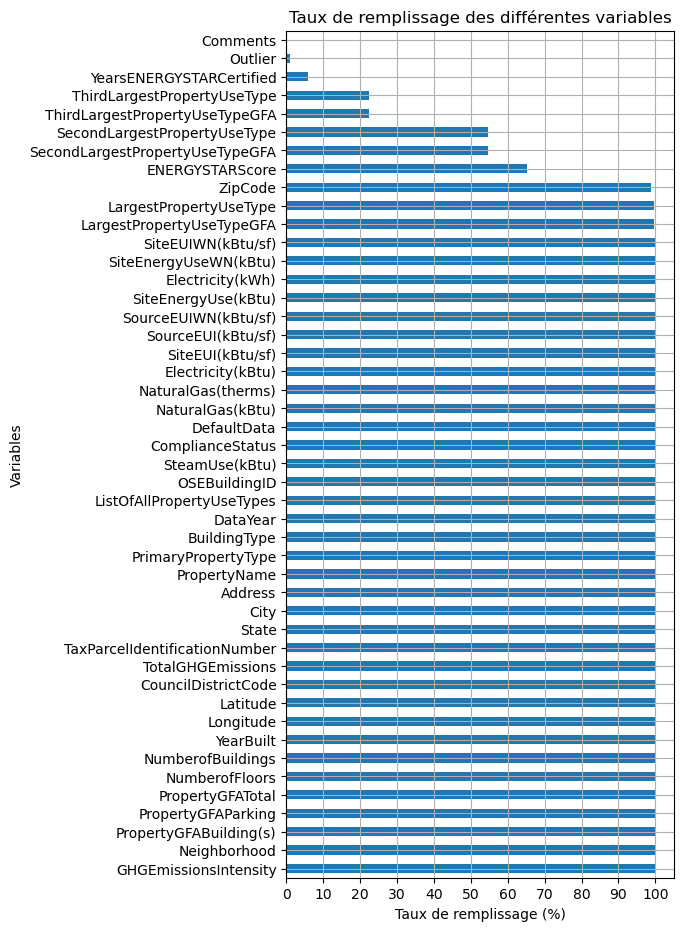

In [22]:
rempl=(data2016f.notnull().mean()*100).sort_values(ascending=False)
rempl.plot(kind='barh', figsize=[5,11], title='Taux de remplissage des différentes variables')
plt.xticks(np.arange(0,110,10))
plt.grid()
plt.xlabel('Taux de remplissage (%)')
plt.ylabel('Variables')

In [23]:
data2016f.sort_values('NumberofFloors', ascending=False).head(5)

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
1359          21611      2016      NonResidential    Worship Facility   
559             775      2016      NonResidential        Large Office   
233             357      2016  Nonresidential COS        Large Office   
292             422      2016      NonResidential        Large Office   
271             399      2016      NonResidential        Large Office   

                        PropertyName                   Address     City State  \
1359  Seattle Chinese Baptist Church  5801 Beacon Avenue South  Seattle    WA   
559           Columbia Center - 2015            701 5th Avenue  Seattle    WA   
233   Seattle Municipal Tower (2030)          700 Fifth Avenue  Seattle    WA   
292                 Two Union Square             601 Union St.  Seattle    WA   
271                1201 Third Avenue              1201 3rd ave  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
1359  98108.0                    2124049098                    2   
559   98104.0                    0942000640                    7   
233   98104.0                    0942000720                    3   
292   98101.0                    1976700125                    7   
271   98101.0                    1974700120                    7   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1359  GREATER DUWAMISH  47.55072 -122.30265       1977                1.0   
559           DOWNTOWN  47.60454 -122.33072       1985                1.0   
233           DOWNTOWN  47.60501 -122.32988       1990                1.0   
292           DOWNTOWN  47.61043 -122.33206       1989                1.0   
271           DOWNTOWN  47.60723 -122.33611       1988                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1359              99             21948                   0   
559               76           1952220              319400   
233               63           1354987              159600   
292               56           1605578              389860   
271               55           1400000              285000   

      PropertyGFABuilding(s)           ListOfAllPropertyUseTypes  \
1359                   21948                    Worship Facility   
559                  1632820                     Office, Parking   
233                  1195387                     Office, Parking   
292                  1215718              Office, Other, Parking   
271                  1115000  Office, Other, Parking, Restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
1359       Worship Facility                    21948.0   
559                  Office                  1680937.0   
233                  Office                  1191115.0   
292                  Office                  1314475.0   
271                  Office                   994116.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
1359                          NaN                              NaN   
559                       Parking                         319368.0   
233                       Parking                         159599.0   
292                       Parking                         389860.0   
271                       Parking                         264481.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1359                         NaN                             NaN   
559                          NaN                             NaN   
233                        Other                         18656.0   
292                        Other                         30744.0   
271                        Other                        133598.0   

          YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
1359                           NaN             80.0         14.900000   
559   2017201620152012200920072006             86.0         55.299999   
233   2014201320112010200920

### correction d'un outlier après vérif manuelle

In [24]:
data2016f.loc[1359,'NumberofFloors']=1
#ou
#del(data2016f.loc[1359])

### Création d'une catégorie 'no outlier'

In [25]:
data2016f['Outlier']=data2016f['Outlier'].fillna('no outlier')

### Création de 2 nouvelles colonnes indicatrices qui donnent le type d'énergie utilisée

In [26]:
data2016f['IndicSteamUse']=np.where(data2016f['SteamUse(kBtu)']>0,True,False)
data2016f['IndicNaturalGas']=np.where(data2016f['NaturalGas(therms)']>0,True,False)

### Création d'une colonne pour indiquer l'existance d'un parking

In [27]:
data2016f['IndicParking']=data2016f['PropertyGFAParking']>0

### Création d'une colonne qui donne le nombre de property use types (2 méthodes)

In [28]:
data2016f['NumberofMainUseType']=data2016f[['LargestPropertyUseType',\
'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].notnull().sum(axis=1)  # 1ere méthode
data2016f['NumberofAllUseType'] = [len(x) for x in data2016f['ListOfAllPropertyUseTypes'].str.split(',')] #2eme methode

In [29]:
data2016f.groupby(['NumberofMainUseType','NumberofAllUseType']).count()
#Il existe des différences de résultats entre les 2 méthodes. Elles seront toutes les 2 conservées

OSEBuildingID  DataYear  BuildingType  \
NumberofMainUseType NumberofAllUseType                                          
0                   1                               3         3             3   
                    13                              1         1             1   
1                   1                             691       691           691   
                    3                               1         1             1   
                    4                               4         4             4   
2                   1                               5         5             5   
                    2                             487       487           487   
                    4                               1         1             1   
                    5                               3         3             3   
3                   2                               6         6             6   
                    3                             203       203           203   
                    4                              75        75            75   
                    5                              36        36            36   
                    6                              17        17            17   
                    7                               4         4             4   
                    8                               1         1             1   
                    9                               1         1             1   
                    11                              1         1             1   

                                        PrimaryPropertyType  PropertyName  \
NumberofMainUseType NumberofAllUseType                                      
0                   1                                     3             3   
                    13                                    1             1   
1                   1                                   691           691   
                    3                                     1             1   
                    4                                     4             4   
2                   1                                     5             5   
                    2                                   487           487   
                    4                                     1             1   
                    5                                     3             3   
3                   2                                     6             6   
                    3                                   203           203   
                    4                                    75            75   
                    5                                    36            36   
                    6                                    17            17   
                    7                                     4             4   
                    8                                     1             1   
                    9                                     1             1   
                    11                                    1             1   

                                        Address  City  State  ZipCode  \
NumberofMainUseType NumberofAllUseType                                  
0                   1                         3     3      3        3   
                    13                        1     1      1        1   
1                   1                       691   691    691      682   
                    3                         1     1      1        1   
                    4                         4     4      4        4   
2                   1                         5     5      5        5   
                    2                       487   487    487      487   
                    4                         1     1      1        1   
                    5                         3     3      3        3   
3                   2                         6     6      6        6   
  

### Création de colonnes avec tous les Property Use Types à partir de la variable ListOfAllPropertyUSeTypes (abandonné car pas d'impact sur le r2)

In [30]:
#PrUsTy=data2016f['ListOfAllPropertyUseTypes'].str.split(',').explode().unique()
#PrUsTy2=[]
#for i in PrUsTy:
 #   n='PrUsTy_{}'.format(i)
  #  PrUsTy2.append(n)    
#DfPrUsTy=pd.DataFrame([[[np.isin(nom,x).any()][0] for x in data2016f['ListOfAllPropertyUseTypes'].str.split(',')] for nom in PrUsTy])
#DfPrUsTy.columns=data2016f.index
#DfPrUsTy2=DfPrUsTy.T
#DfPrUsTy2.columns=PrUsTy2
#data2016f=data2016f.join(DfPrUsTy2)
#data2016f

### Labels en fonction de la situation géographique (abandonné)

In [31]:
#plt.figure(figsize=[8,8])
#sns.scatterplot(data=data2016f, x='Longitude', y='Latitude', hue='TotalGHGEmissions', palette='mako')
#plt.figure(figsize=[8,8])
#sns.scatterplot(data=data2016f, x='Longitude', y='Latitude', hue='SiteEnergyUse(kBtu)', palette='viridis')

In [32]:
data2016f.select_dtypes('number').columns

Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'NumberofMainUseType', 'NumberofAllUseType'],
      dtype='object')

### vérification de la relation entre les colonnes GFA

#### copier/coller des informations du site concernant les colonnes

In [33]:
# PropertyGFAParking 
# Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open."

# PropertyGFATotal
# Total building and parking gross floor area

# PropertyGFABuildings
# "Total floor space in square feet between the outside surfaces of a building’s enclosing walls. 
#This includes all areas inside the building(s),such as tenant space, common areas, stairwells, basements, storage, etc. "

#LargestPropertyUseTypeGFA
#The largest use of a property (e.g. office, retail store) by GFA. 
# "The gross floor area (GFA) of the largest use of the property."

#PrimaryPropertyType
#"The primary use of a property (e.g. office, retail store). 
#Primary use is defined as a function that accounts for more than 50% of a property. 

In [34]:
# Un dataframe à part pour vérifier les relations entre les variables
dataGFA=data2016f.copy()
dataGFA=dataGFA[['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',\
           'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].fillna(0)
dataGFA.columns=['Total','Parking','Buildings','L1','L2','L3']
dataGFA['ParkBui']=(dataGFA['Buildings']+dataGFA['Parking'])/dataGFA['Total']  # vérifié. toujours égal à 1
dataGFA['PropBui']=dataGFA['Buildings']/dataGFA['Total'] # vérifié. ne dépasse jamais 1
dataGFA['PropL123Tot']=(dataGFA['L1'].fillna(0)+dataGFA['L2'].fillna(0)+dataGFA['L3'].fillna(0))/dataGFA['Total'] 
dataGFA['PropL123Bui']=(dataGFA['L1'].fillna(0)+dataGFA['L2'].fillna(0)+dataGFA['L3']).fillna(0)/dataGFA['Buildings'] 
dataGFA.sort_values(['PropL123Tot'], ascending=False)

Total  Parking  Buildings        L1       L2     L3  ParkBui   PropBui  \
3165   45700        0      45700  293707.0      0.0    0.0      1.0  1.000000   
2246   16300        0      16300   65164.0      0.0    0.0      1.0  1.000000   
3294   33648        0      33648   83600.0  39000.0    0.0      1.0  1.000000   
619    62600        0      62600  215197.0      0.0    0.0      1.0  1.000000   
3132   21931        0      21931   31845.0  31845.0    0.0      1.0  1.000000   
...      ...      ...        ...       ...      ...    ...      ...       ...   
3267  197395   156000      41395   38800.0   3650.0  586.0      1.0  0.209706   
1147   61721        0      61721       0.0      0.0    0.0      1.0  1.000000   
2414   48350        0      48350       0.0      0.0    0.0      1.0  1.000000   
2459   28800        0      28800       0.0      0.0    0.0      1.0  1.000000   
353   111445        0     111445       0.0      0.0    0.0      1.0  1.000000   

      PropL123Tot  PropL123Bui  
3165     6.426849     6.426849  
2246     3.997791     3.997791  
3294     3.643604     3.643604  
619      3.437652     3.437652  
3132     2.904108     2.904108  
...           ...          ...  
3267     0.218020     1.039642  
1147     0.000000     0.000000  
2414     0.000000     0.000000  
2459     0.000000     0.000000  
353      0.000000     0.000000  

[1540 rows x 10 columns]

In [35]:
(dataGFA['PropL123Tot']>1).mean() #proportion des enregistrements dont la somme des 3 dépasse le total

0.2435064935064935

### création de colonnes qui indiquent si ThirdLargestPropertyUseTypeGFA et SecondLargestPropertyUseTypeGFA ont une valeur nulle, non-nulle ou N/A

In [36]:
data2016f['typeThi']=np.nan
data2016f.loc[data2016f['ThirdLargestPropertyUseTypeGFA']==0,'typeThi']='zero'
data2016f.loc[data2016f['ThirdLargestPropertyUseTypeGFA']>0,'typeThi']='valeur'
data2016f.loc[pd.isnull(data2016f['ThirdLargestPropertyUseTypeGFA']),'typeThi']='zero'
data2016f['typeSec']=np.nan
data2016f.loc[data2016f['SecondLargestPropertyUseTypeGFA']==0,'typeSec']='zero'
data2016f.loc[data2016f['SecondLargestPropertyUseTypeGFA']>0,'typeSec']='valeur'
data2016f.loc[pd.isnull(data2016f['SecondLargestPropertyUseTypeGFA']),'typeSec']='zero'

### Remplacement des valeurs nulles par 0 dans les champs SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseTypeGFA 

In [37]:
data2016f['SecondLargestPropertyUseTypeGFA']=data2016f['SecondLargestPropertyUseTypeGFA'].fillna(0)
data2016f['ThirdLargestPropertyUseTypeGFA']=data2016f['ThirdLargestPropertyUseTypeGFA'].fillna(0)

### Traitement des NumberofBuildings à 0

In [38]:
data2016f.loc[data2016f['NumberofBuildings']==0,'NumberofBuildings']=np.nan
data2016f['NumberofBuildings'].fillna('mean')

0       1
1       1
2       1
3       1
4       1
       ..
3371    1
3372    1
3373    1
3374    1
3375    1
Name: NumberofBuildings, Length: 1540, dtype: object

### Test de nouvelles variables liées aux surfaces

In [39]:
# Surface moyenne par étage
data2016f['SurfEtaMoy']=data2016f['PropertyGFABuilding(s)']/(data2016f['NumberofFloors']+1)
# Surface moyenne par bâtiment
data2016f['SurfBatMoy']=data2016f['PropertyGFABuilding(s)']/(data2016f['NumberofBuildings'])
# Somme de 'LargestPropertyUseTypeGFA' 'SecondLargestPropertyUseTypeGFA' et 'ThirdLargestPropertyUseTypeGFA'
data2016f['SumLarSecThiGFA']=data2016f['ThirdLargestPropertyUseTypeGFA']+\
data2016f['SecondLargestPropertyUseTypeGFA']+data2016f['LargestPropertyUseTypeGFA']
#proportion de buildings dans le GFA total
data2016f['PropBuildingsGFA']=data2016f['PropertyGFABuilding(s)']/data2016f['PropertyGFATotal']
#LargestPropertyUseType identique au PrimaryPropertyType
data2016f['PrimEqualLarg']=data2016f['LargestPropertyUseType']==data2016f['PrimaryPropertyType']

### Création d'une catégorie 'NonRenseigné' pour les valeurs vides des catégories

In [40]:
ColonnesCategories=data2016f.select_dtypes('O').columns
data2016f[ColonnesCategories]=data2016f[ColonnesCategories].fillna('NonRenseigne')

In [41]:
data2016f.select_dtypes('number').columns

Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'NumberofMainUseType', 'NumberofAllUseType', 'SurfEtaMoy', 'SurfBatMoy',
       'SumLarSecThiGFA', 'PropBuildingsGFA'],
      dtype='object')

In [42]:
data2016f['NumberofBuildings'].describe()

count    1488.000000
mean        1.072581
std         0.545299
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: NumberofBuildings, dtype: float64

### Distribution des variables numériques, brutes ou après transformations

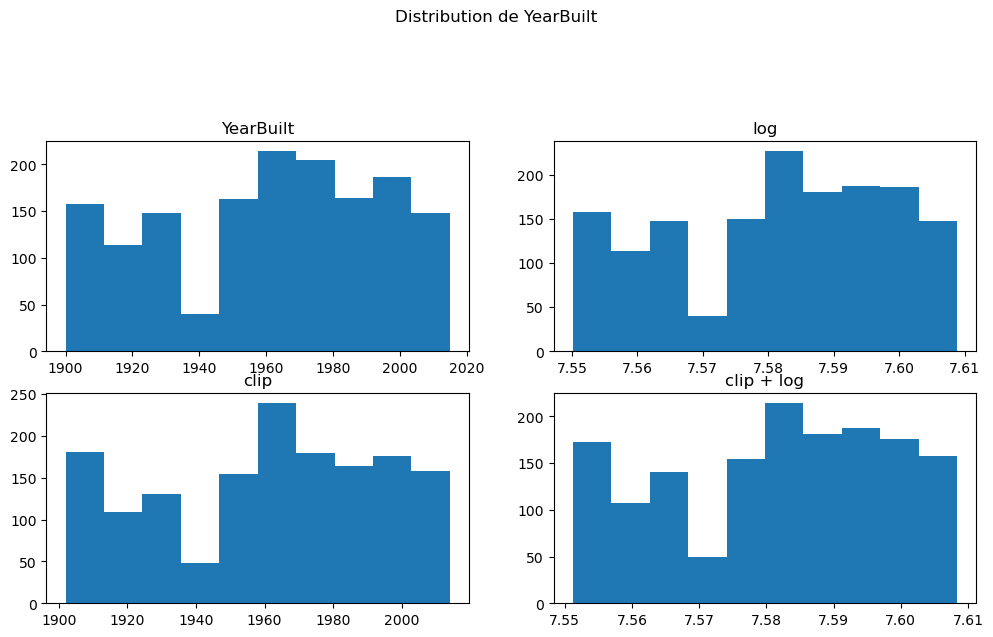

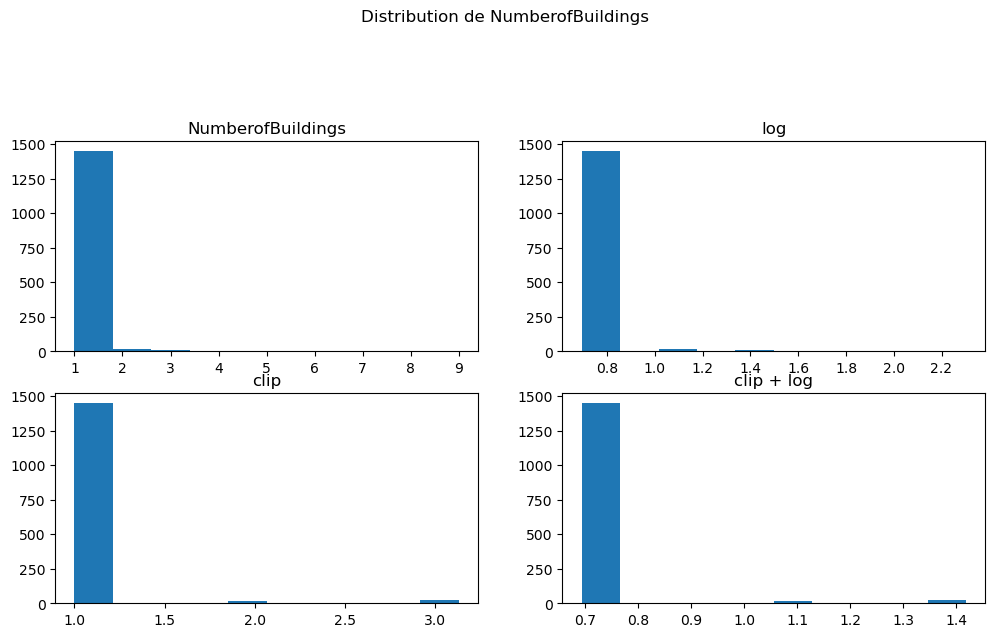

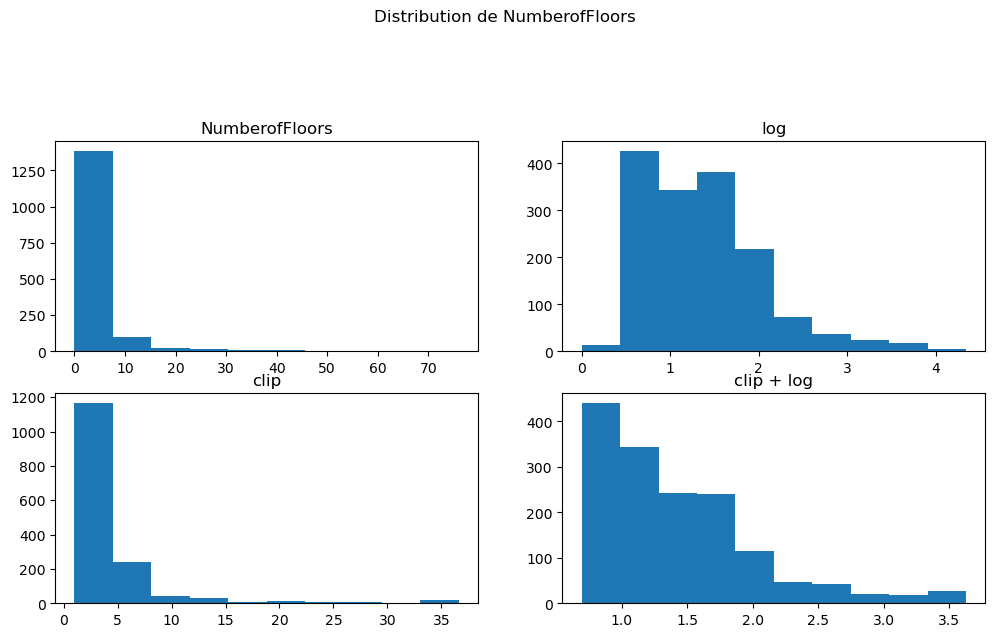

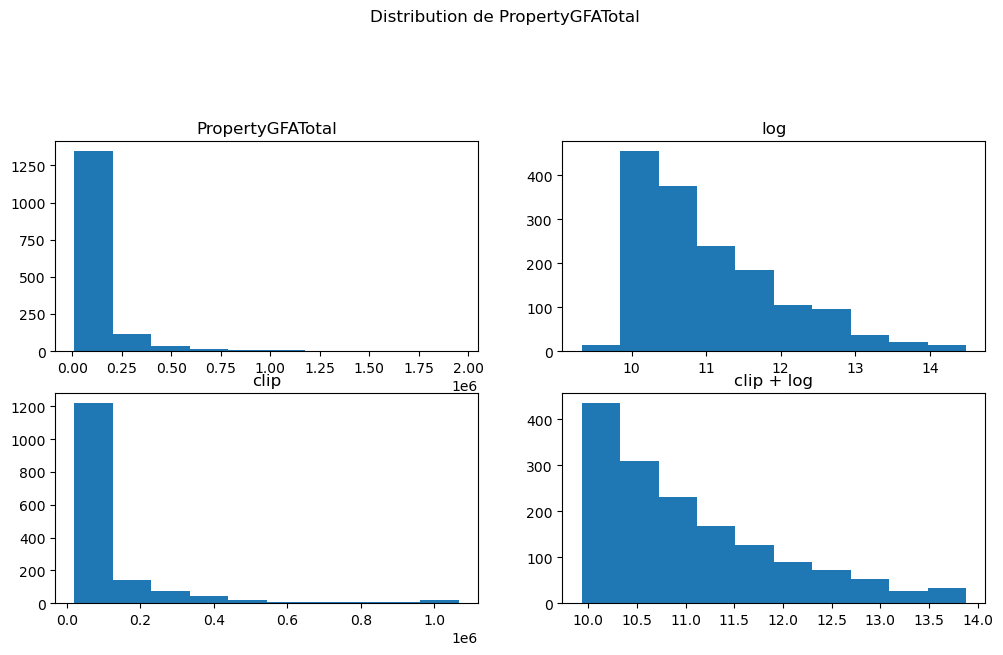

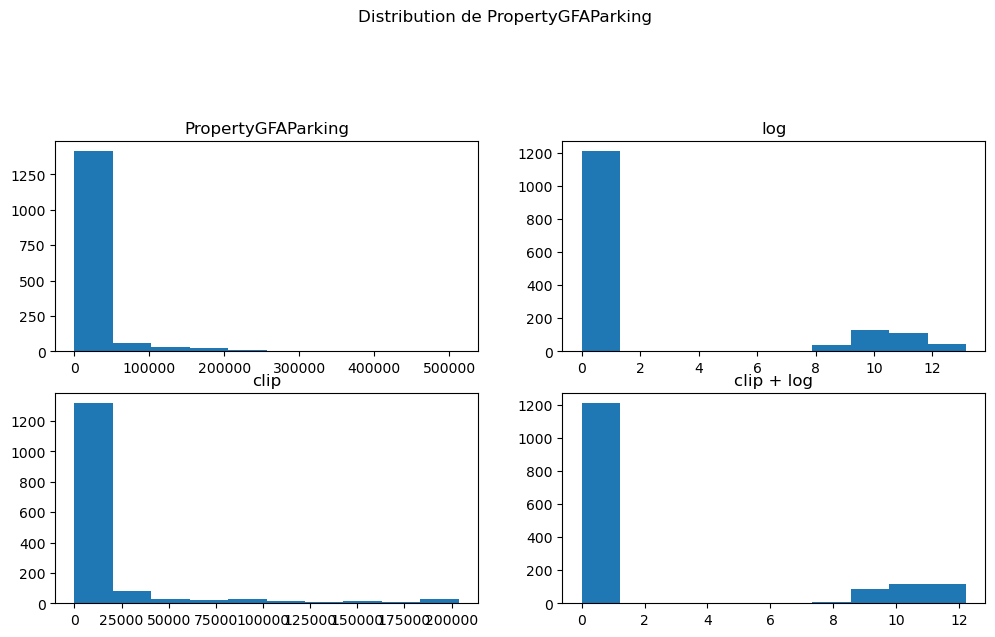

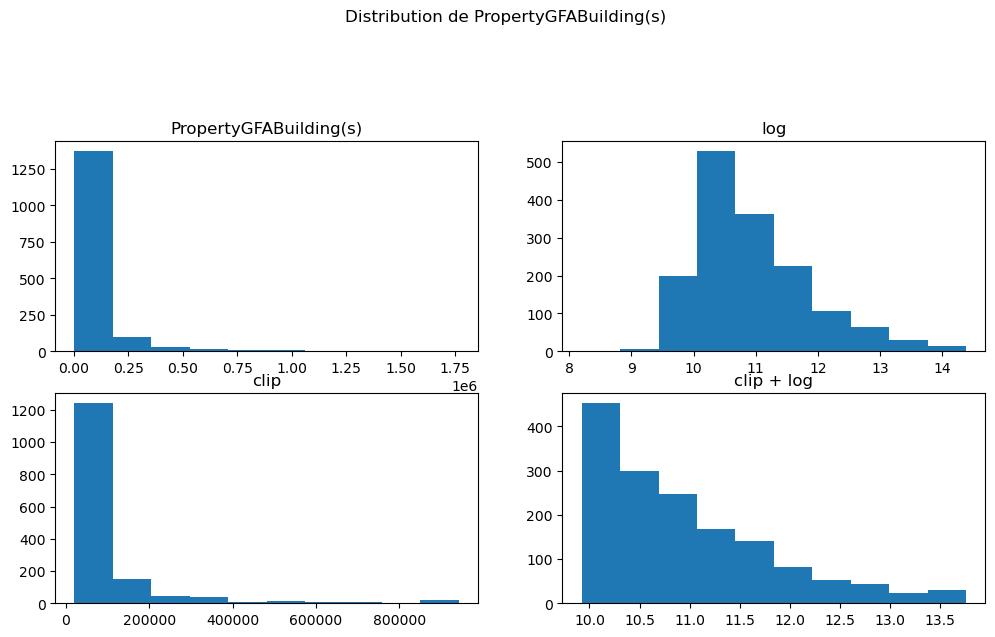

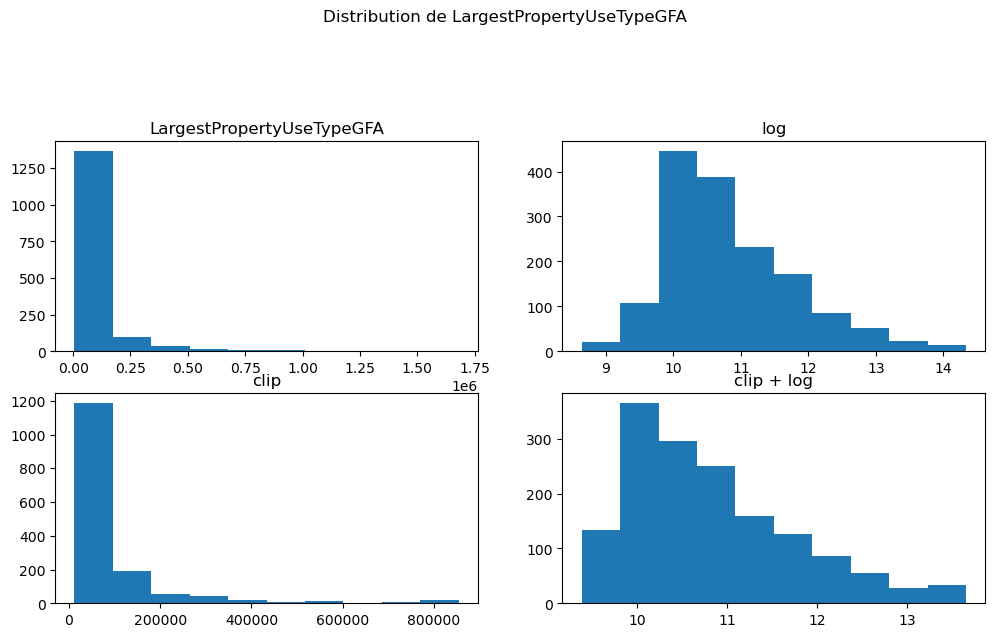

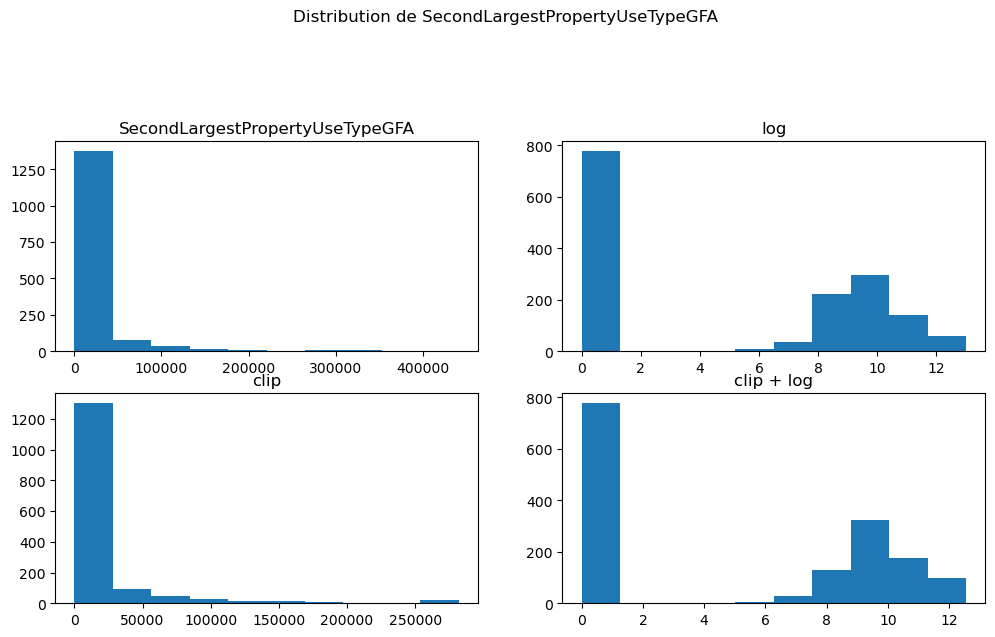

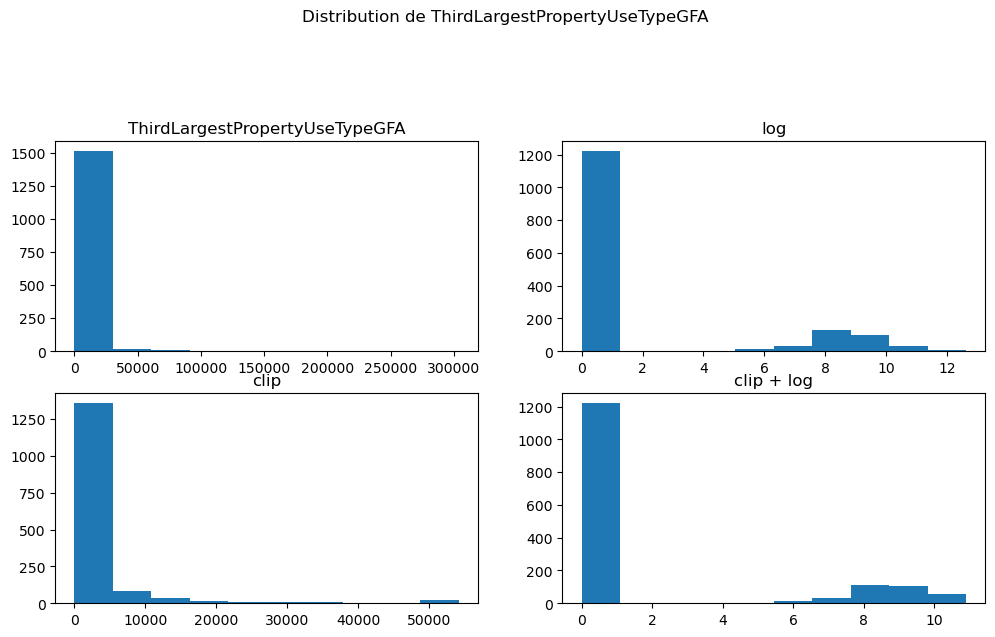

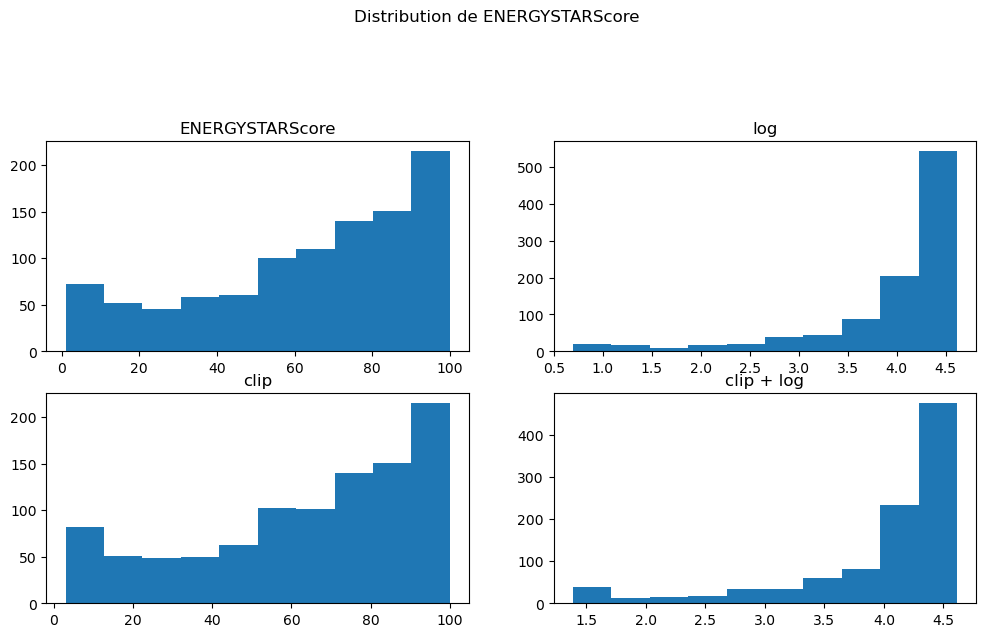

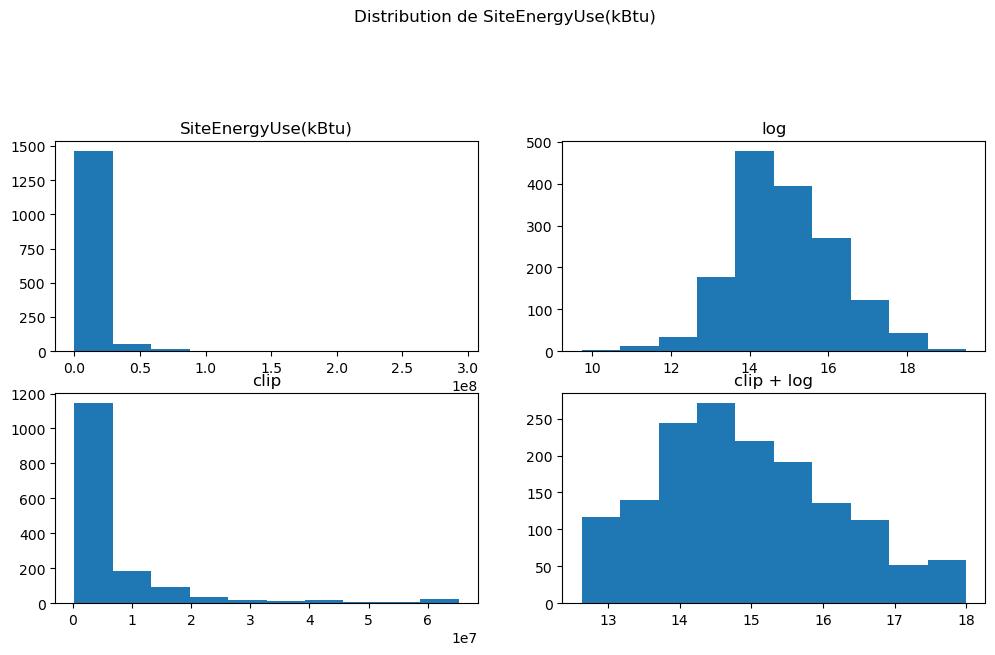

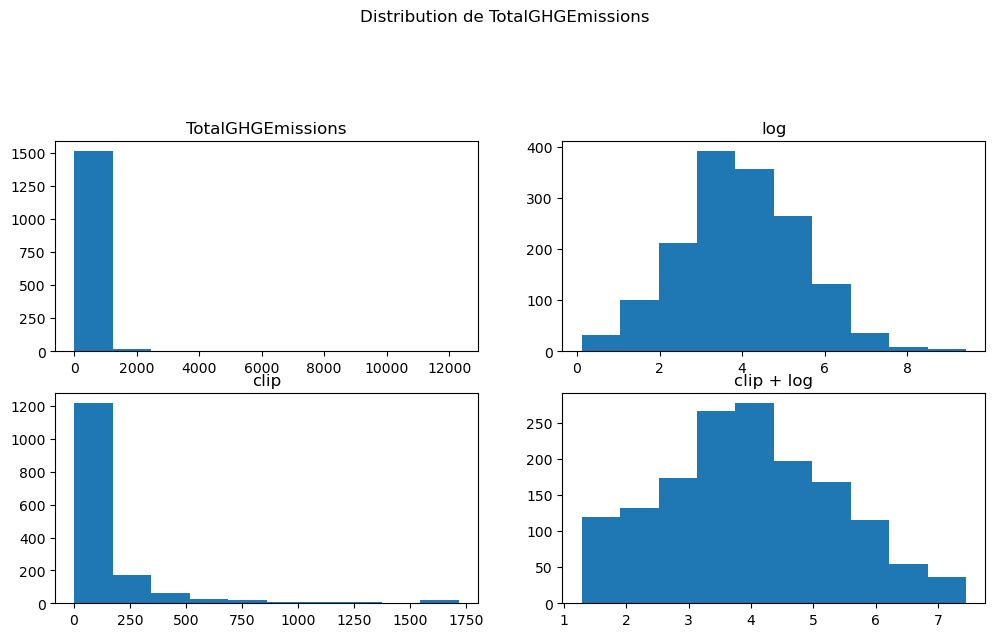

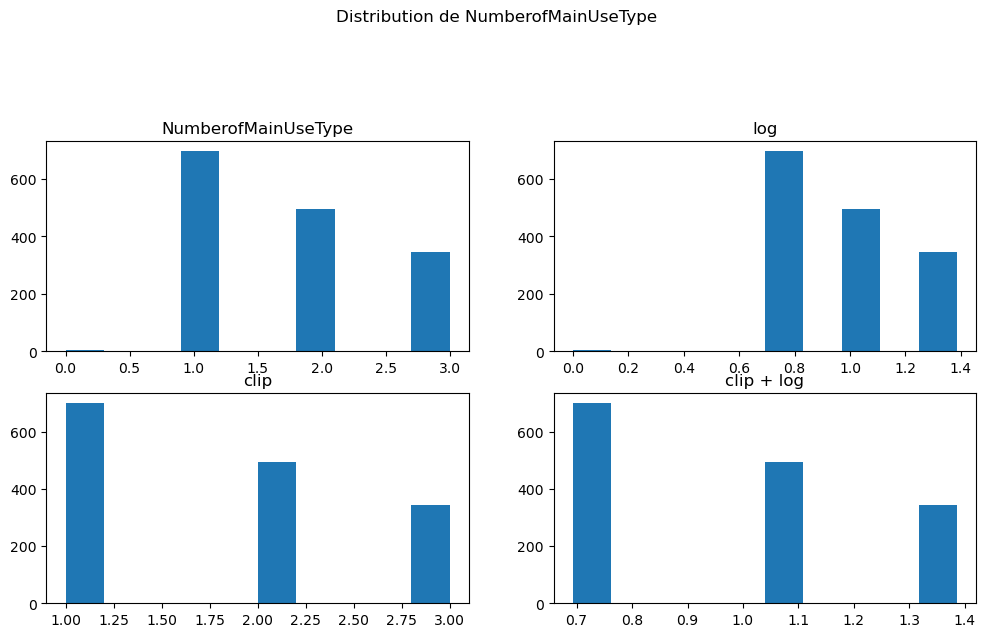

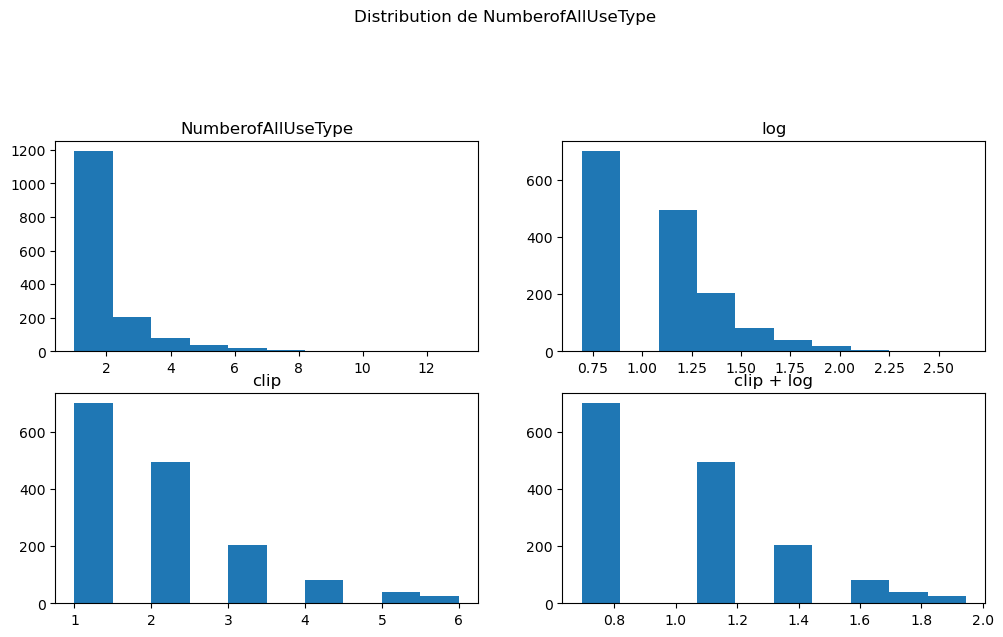

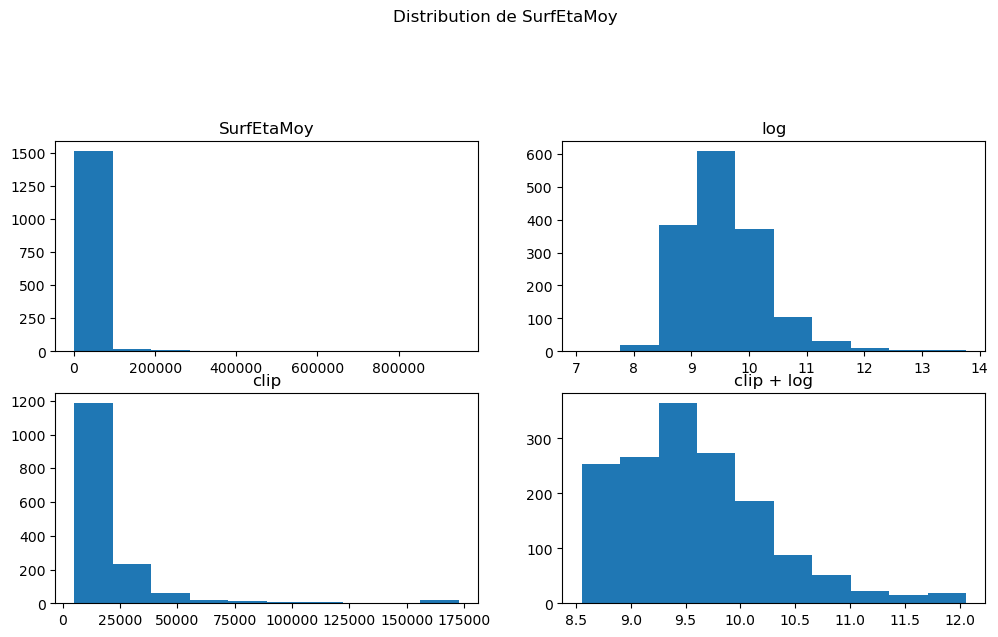

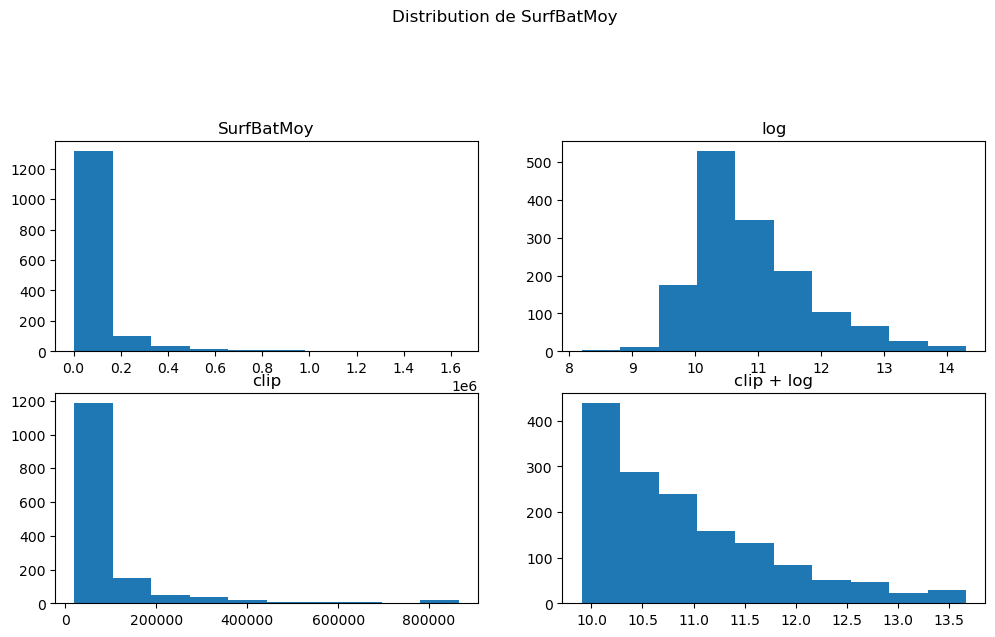

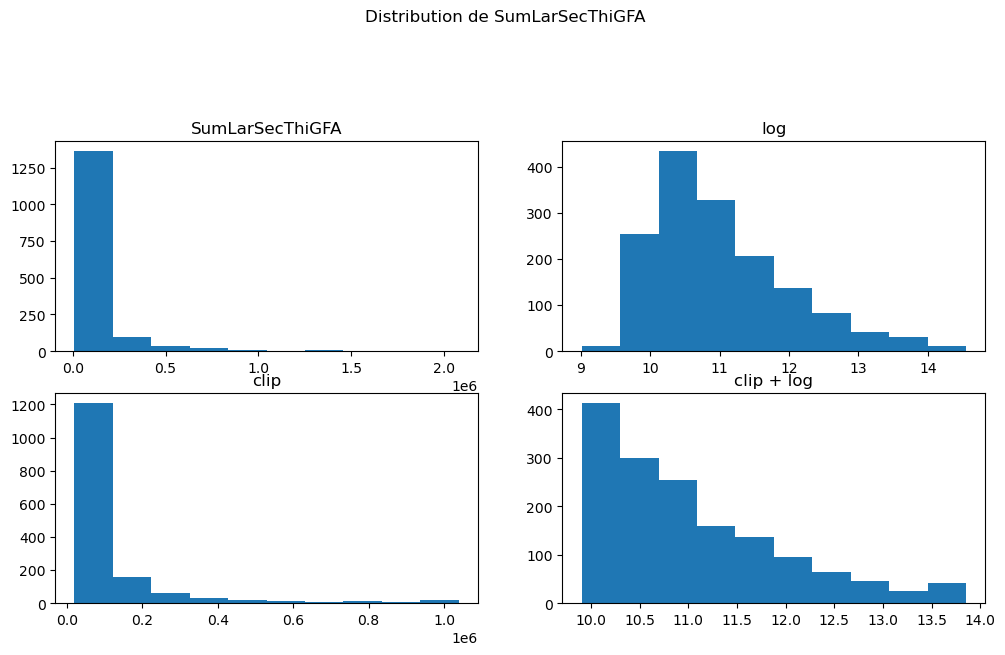

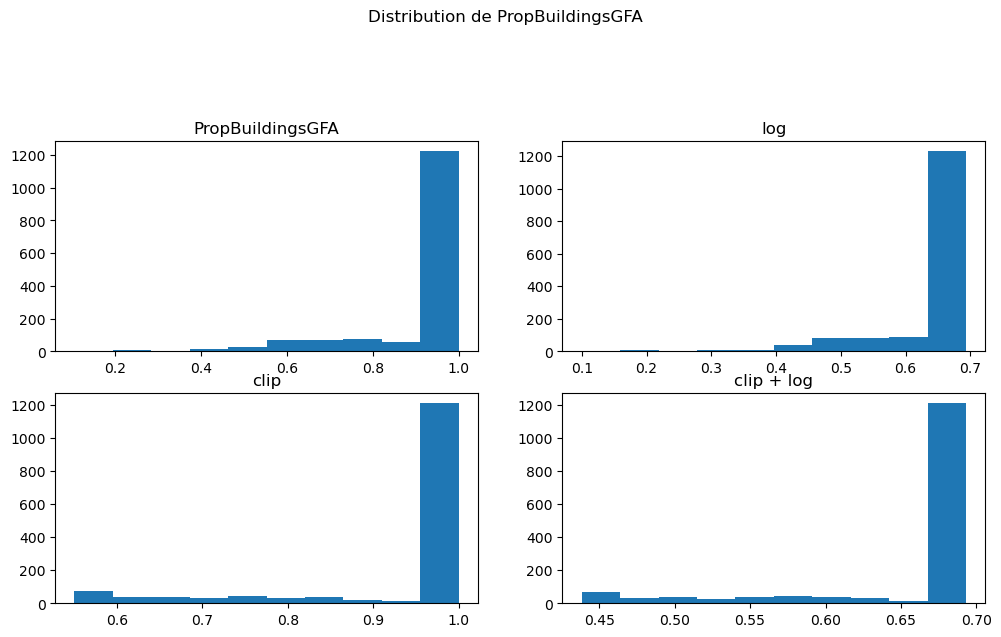

In [43]:
l=0.03 #test de "clips" des 3% de valeurs les plus faibles
h=0.99 # et des 1% de valeurs les plus élevées

if graphs == True :
    sel=['YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)','TotalGHGEmissions', 
       'NumberofMainUseType', 'NumberofAllUseType', 'SurfEtaMoy', 'SurfBatMoy',
       'SumLarSecThiGFA', 'PropBuildingsGFA']
    for i in sel :
        plt.subplots(2,2, figsize=[12,6])
        plt.suptitle('Distribution de {}'.format(i),y=1.1)
        plt.subplot(221)
        plt.hist(data2016f[i].dropna())
        plt.title(i)
        plt.subplot(222)
        plt.hist(np.log1p(data2016f[i]).dropna())
        plt.title("log")
        plt.subplot(223)
        plt.hist(data2016f[i].clip(lower=data2016f[i].quantile(q=l),upper=data2016f[i].quantile(q=h)).dropna())
        plt.title("clip")
        plt.subplot(224)
        plt.hist(np.log1p(data2016f[i].clip(lower=data2016f[i].quantile(q=l),upper=data2016f[i].quantile(q=h)).dropna()))
        plt.title("clip + log")
        plt.show()

### clip des valeurs numériques les plus extrèmes 

In [44]:
high=0.99   
low=0.04
ValClip=[]
for i in ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 
       'NumberofAllUseType']:
        #nom='{}_cl'.format(i)
        data2016f[i]=data2016f[i].clip(lower=data2016f[i].quantile(q=low),upper=data2016f[i].quantile(q=high))
        ValClip.append(i)

### Mise au log de certaines colonnes pour obtenir une distribution plus proche d'une distribution normale

In [45]:
LogLabel =[]
Log=[]
for i in ['TotalGHGEmissions','SiteEnergyUse(kBtu)'] : #les labels
    data2016f[i]=np.log1p(data2016f[i]) 
    LogLabel.append(i)
for j in ['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','NumberofFloors',
         'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','SumLarSecThiGFA','SurfEtaMoy','SurfBatMoy']:
    # les autres variables
    data2016f[j]=np.log1p(data2016f[j]) #transformation log
    Log.append(j)

In [46]:
data2016f.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### Mise de coté de colonnes jugées inutiles

In [47]:
inutiles=['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','Neighborhood',
        'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode','Latitude', 'Longitude', 'DataYear','Comments',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)','YearsENERGYSTARCertified','typeSec','DefaultData',
       'NaturalGas(kBtu)',  'GHGEmissionsIntensity','ListOfAllPropertyUseTypes','ComplianceStatus']
data2016f2=data2016f.copy() #nouveau dataframe pour éviter les erreurs
data2016f2=data2016f2.loc[:,np.isin(data2016f2.columns,inutiles,invert=True)]
data2016f2.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'Outlier',
       'TotalGHGEmissions', 'IndicSteamUse', 'IndicNaturalGas', 'IndicParking',
       'NumberofMainUseType', 'NumberofAllUseType', 'typeThi', 'SurfEtaMoy',
       'SurfBatMoy', 'SumLarSecThiGFA', 'PropBuildingsGFA', 'PrimEqualLarg'],
      dtype='object')

In [48]:
data2016f2.select_dtypes('number').columns

Index(['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'NumberofMainUseType',
       'NumberofAllUseType', 'SurfEtaMoy', 'SurfBatMoy', 'SumLarSecThiGFA',
       'PropBuildingsGFA'],
      dtype='object')

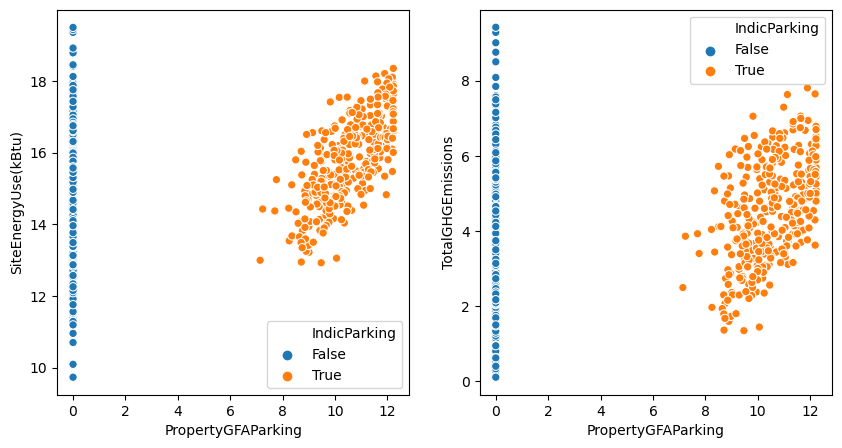

In [49]:
#graph pour illustrer la nécessité de créer des variables indicatrices
plt.subplots(1,2,figsize=[10,5])
plt.subplot(121)
sns.scatterplot(data=data2016f2, x='PropertyGFAParking', y='SiteEnergyUse(kBtu)', hue='IndicParking')
plt.subplot(122)
sns.scatterplot(data=data2016f2, x='PropertyGFAParking', y='TotalGHGEmissions', hue='IndicParking')

### Relation catégories / labels

In [50]:
Categ=data2016f2.select_dtypes(exclude='number')

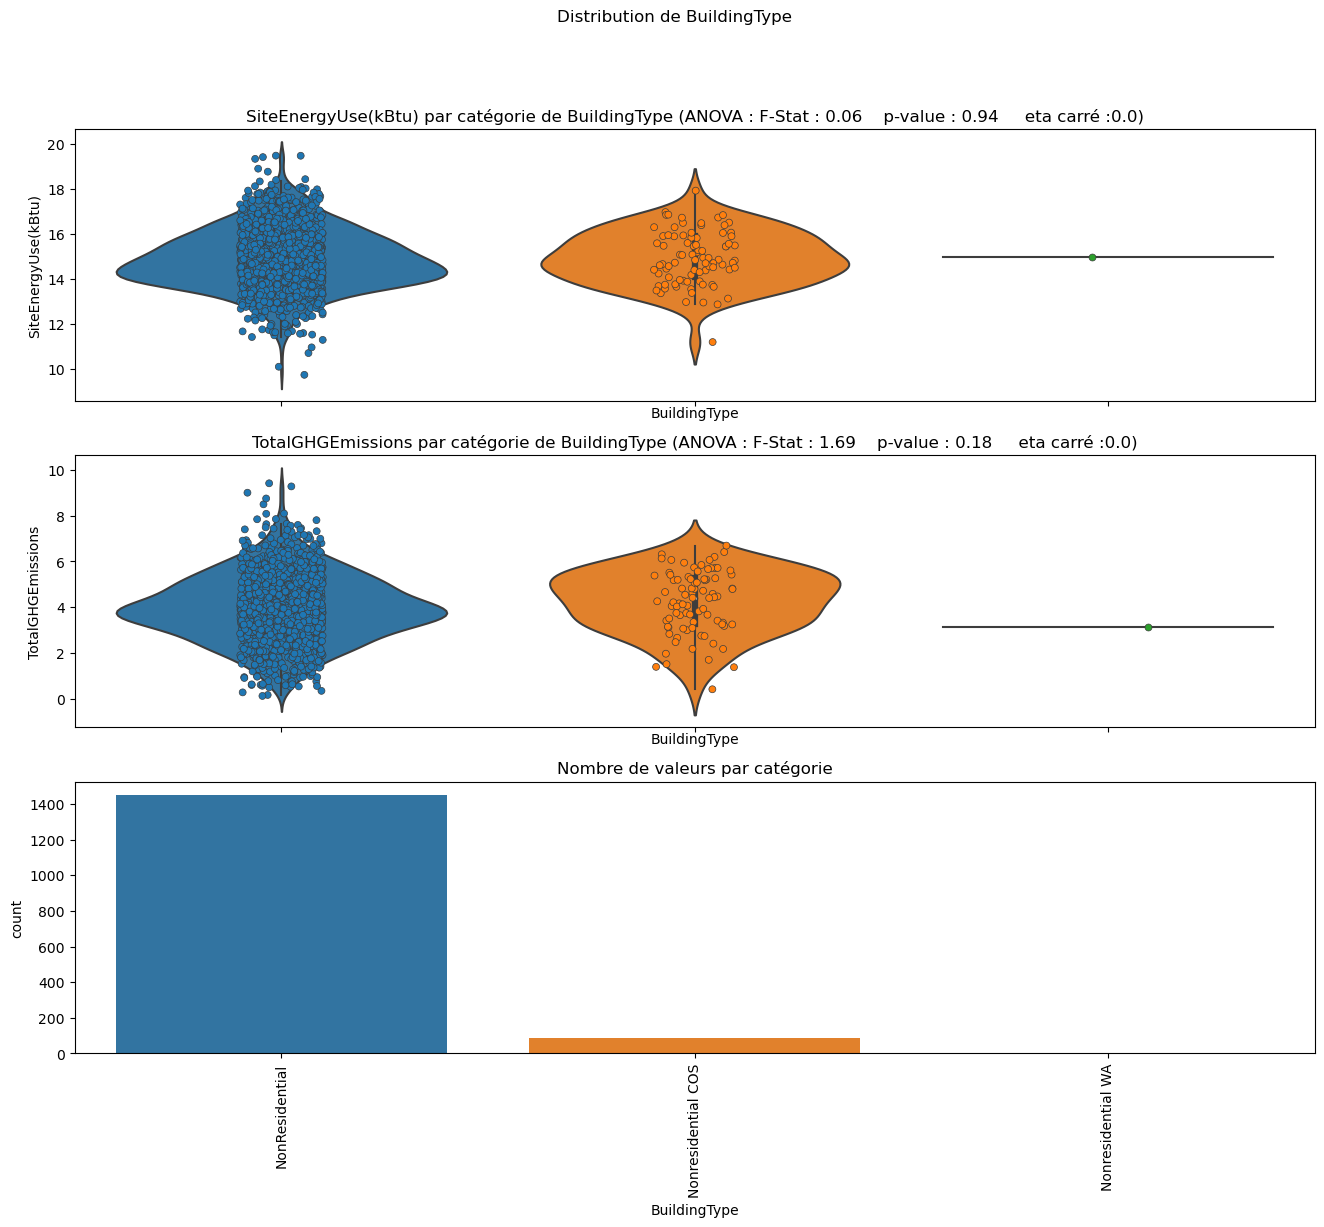

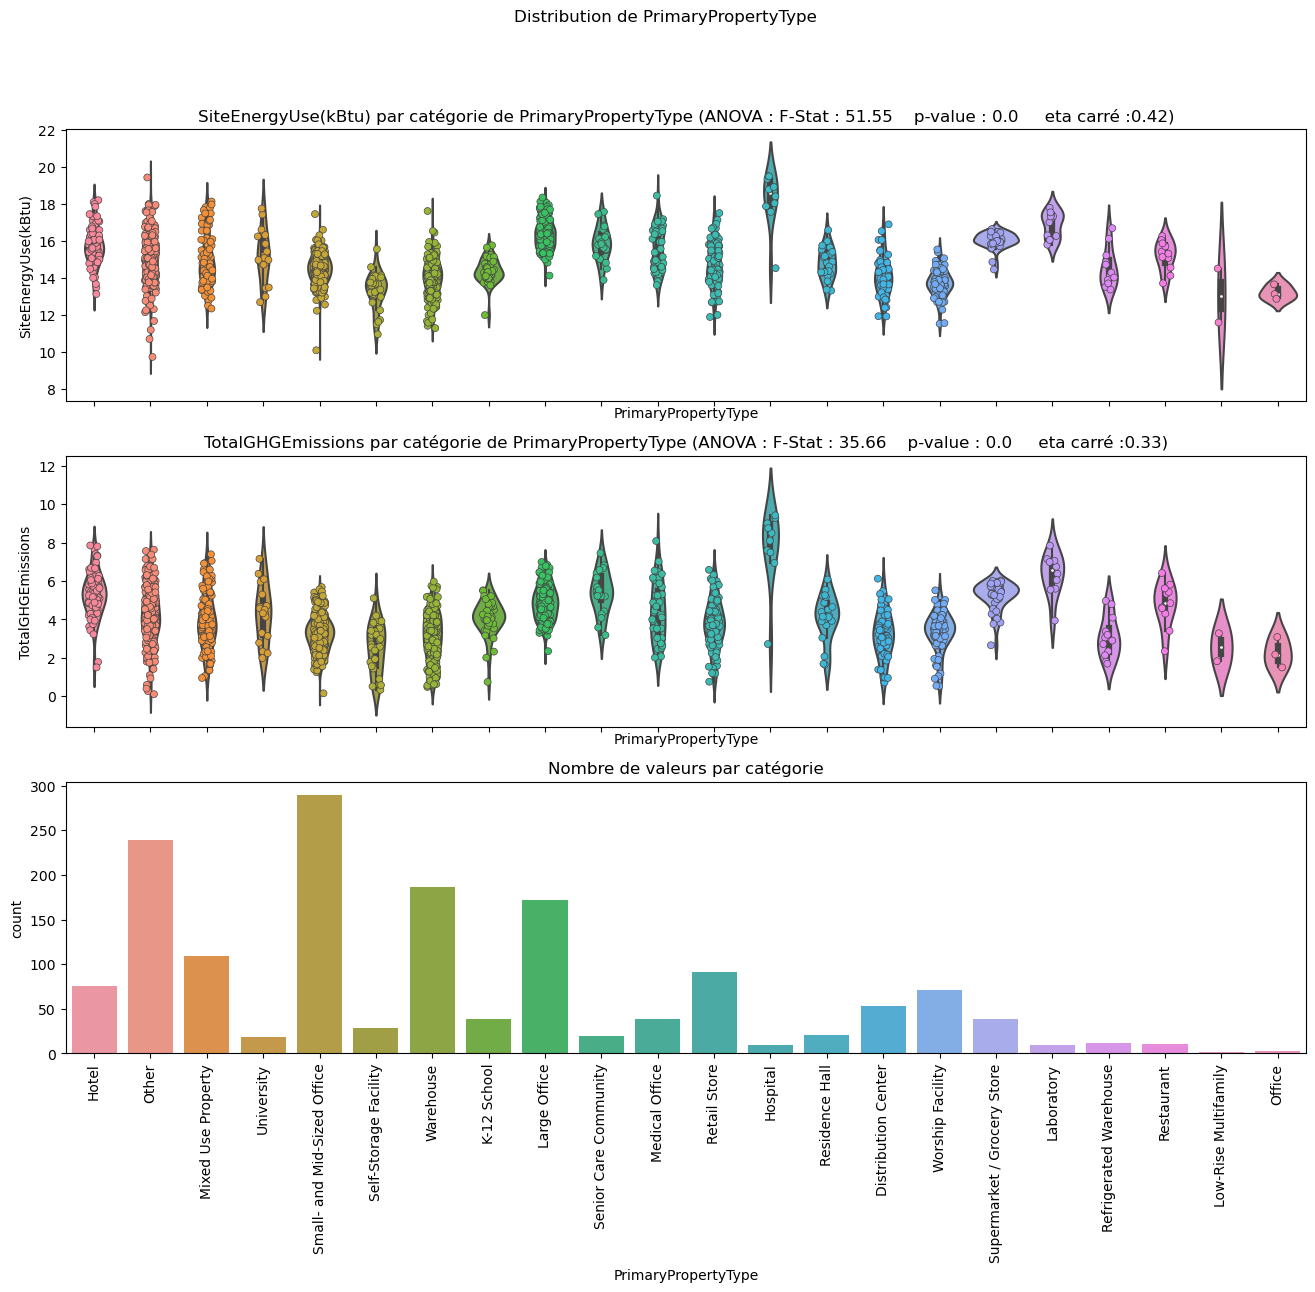

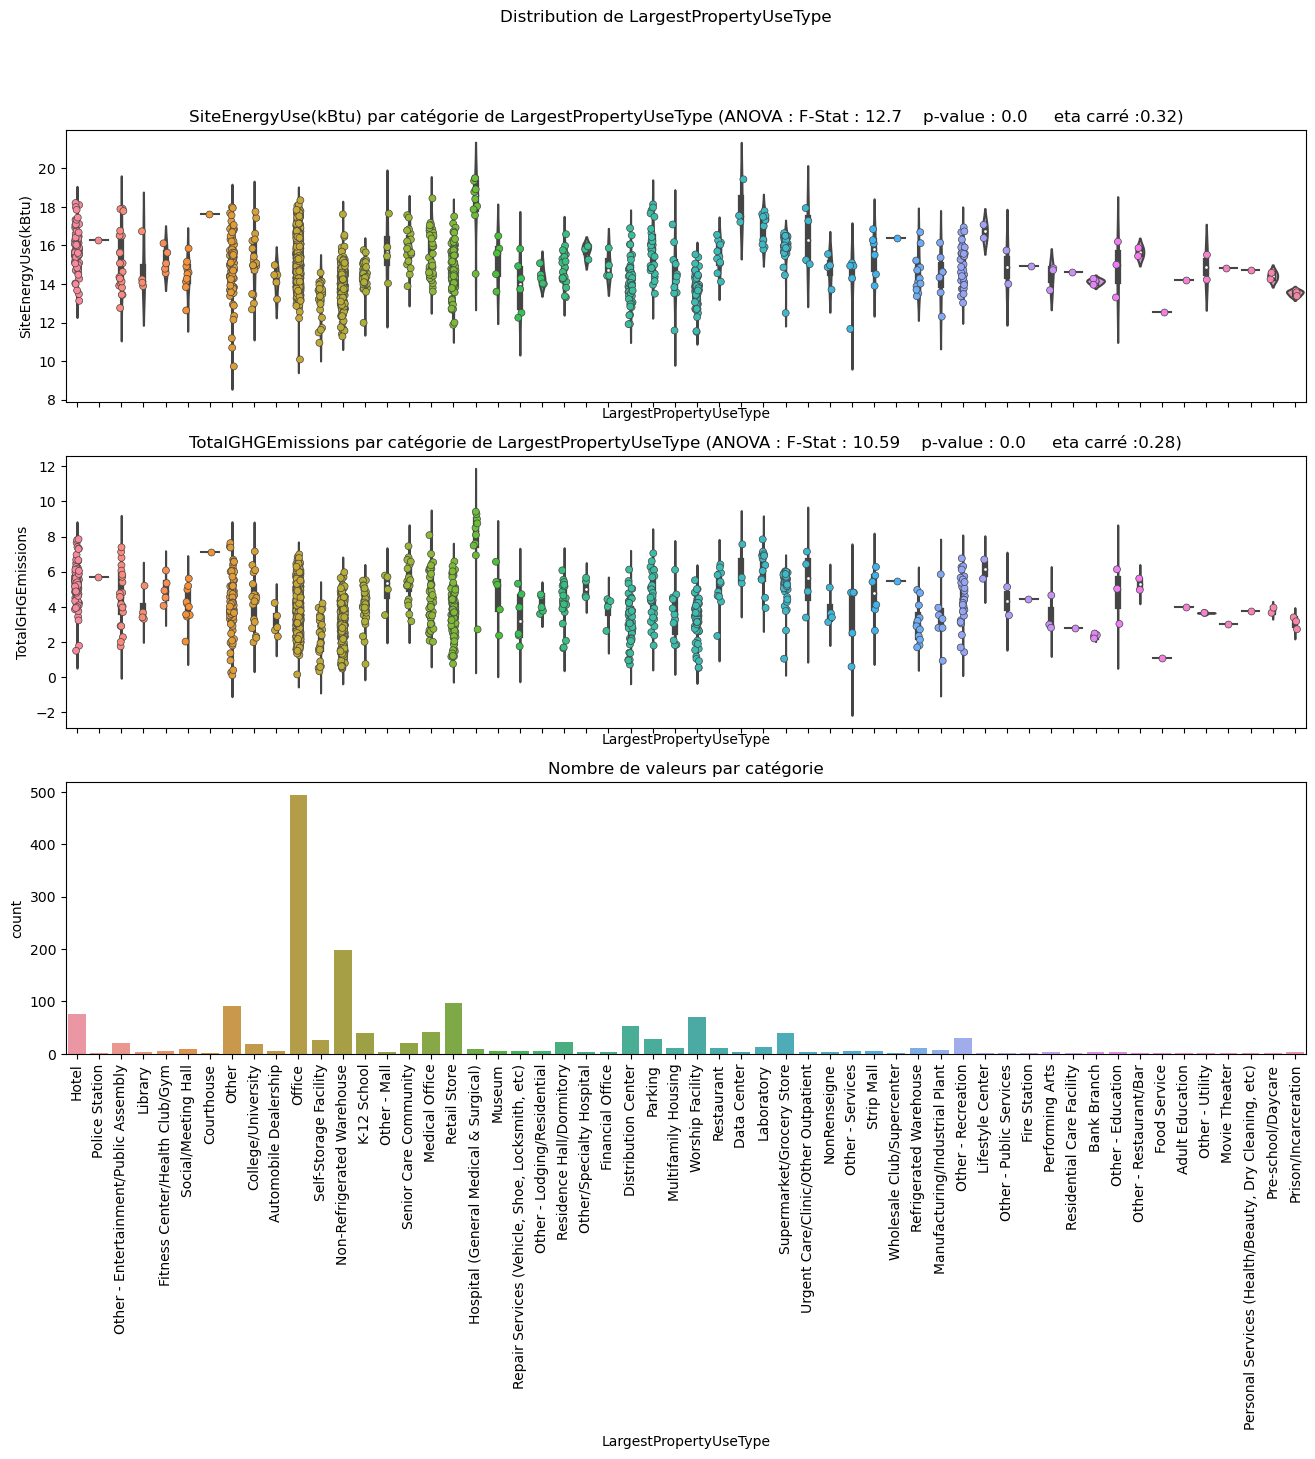

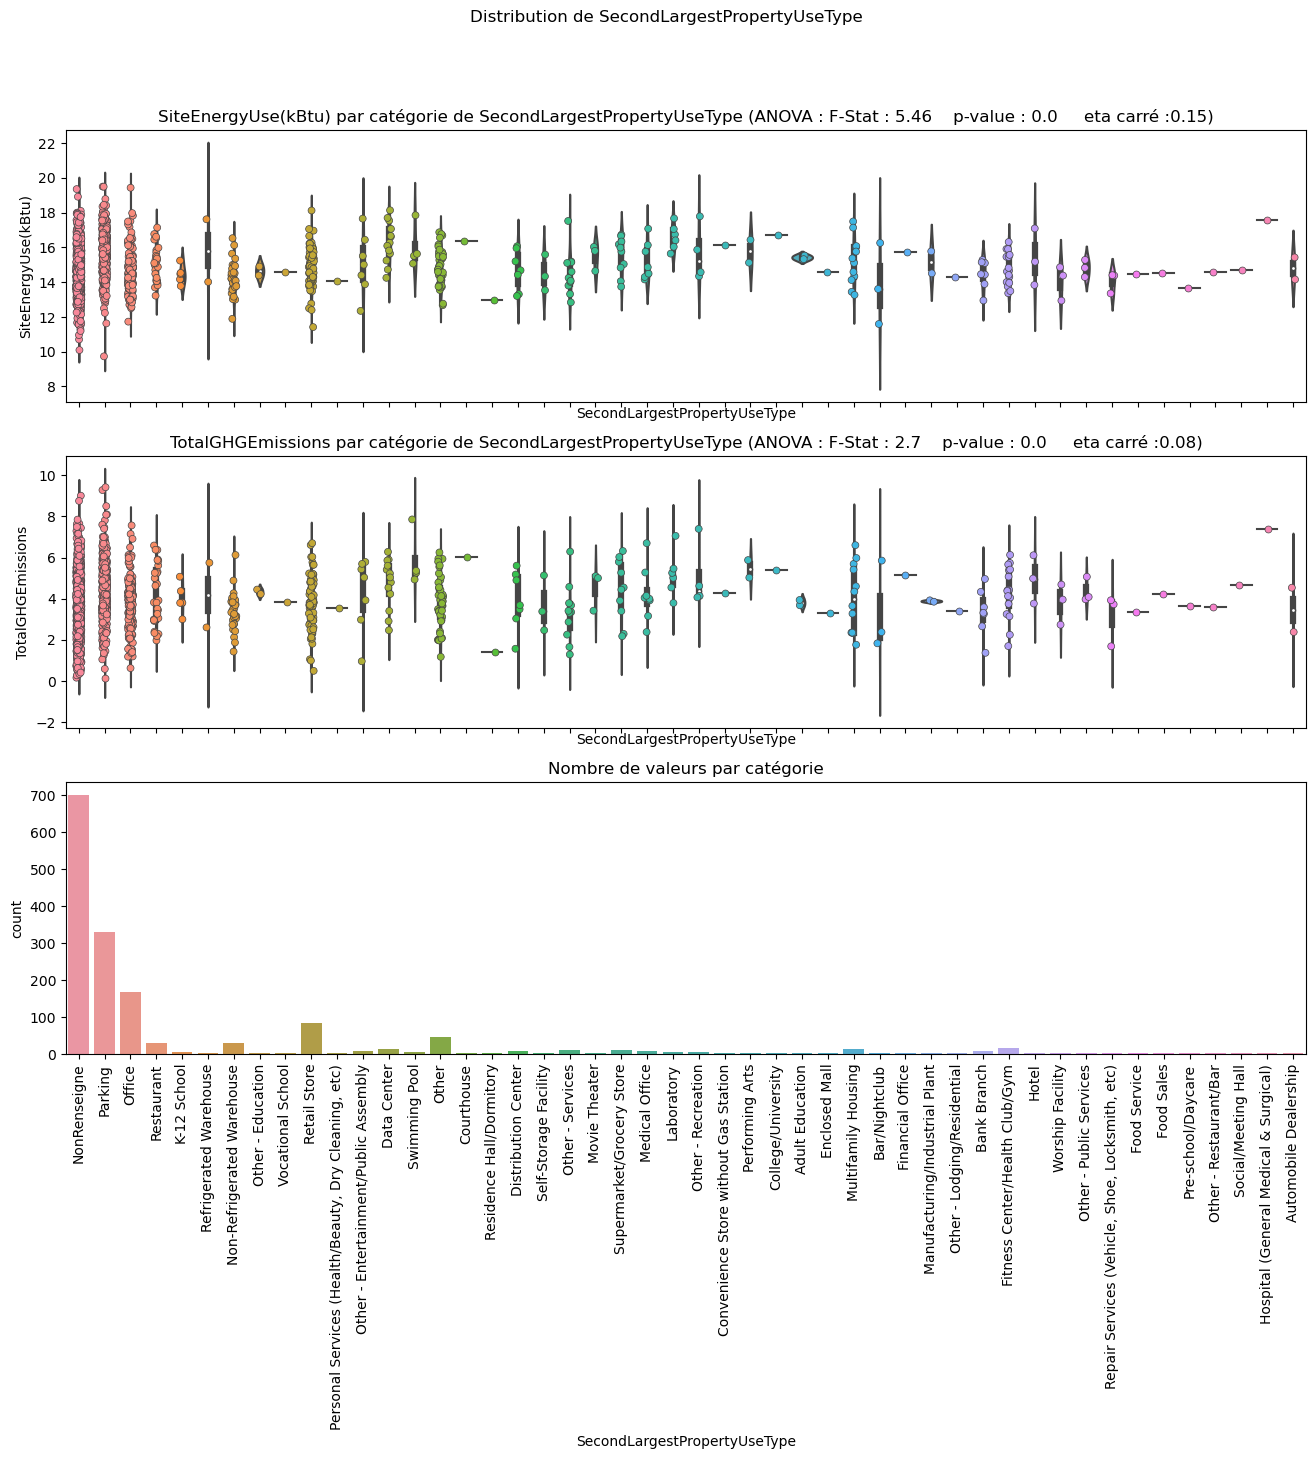

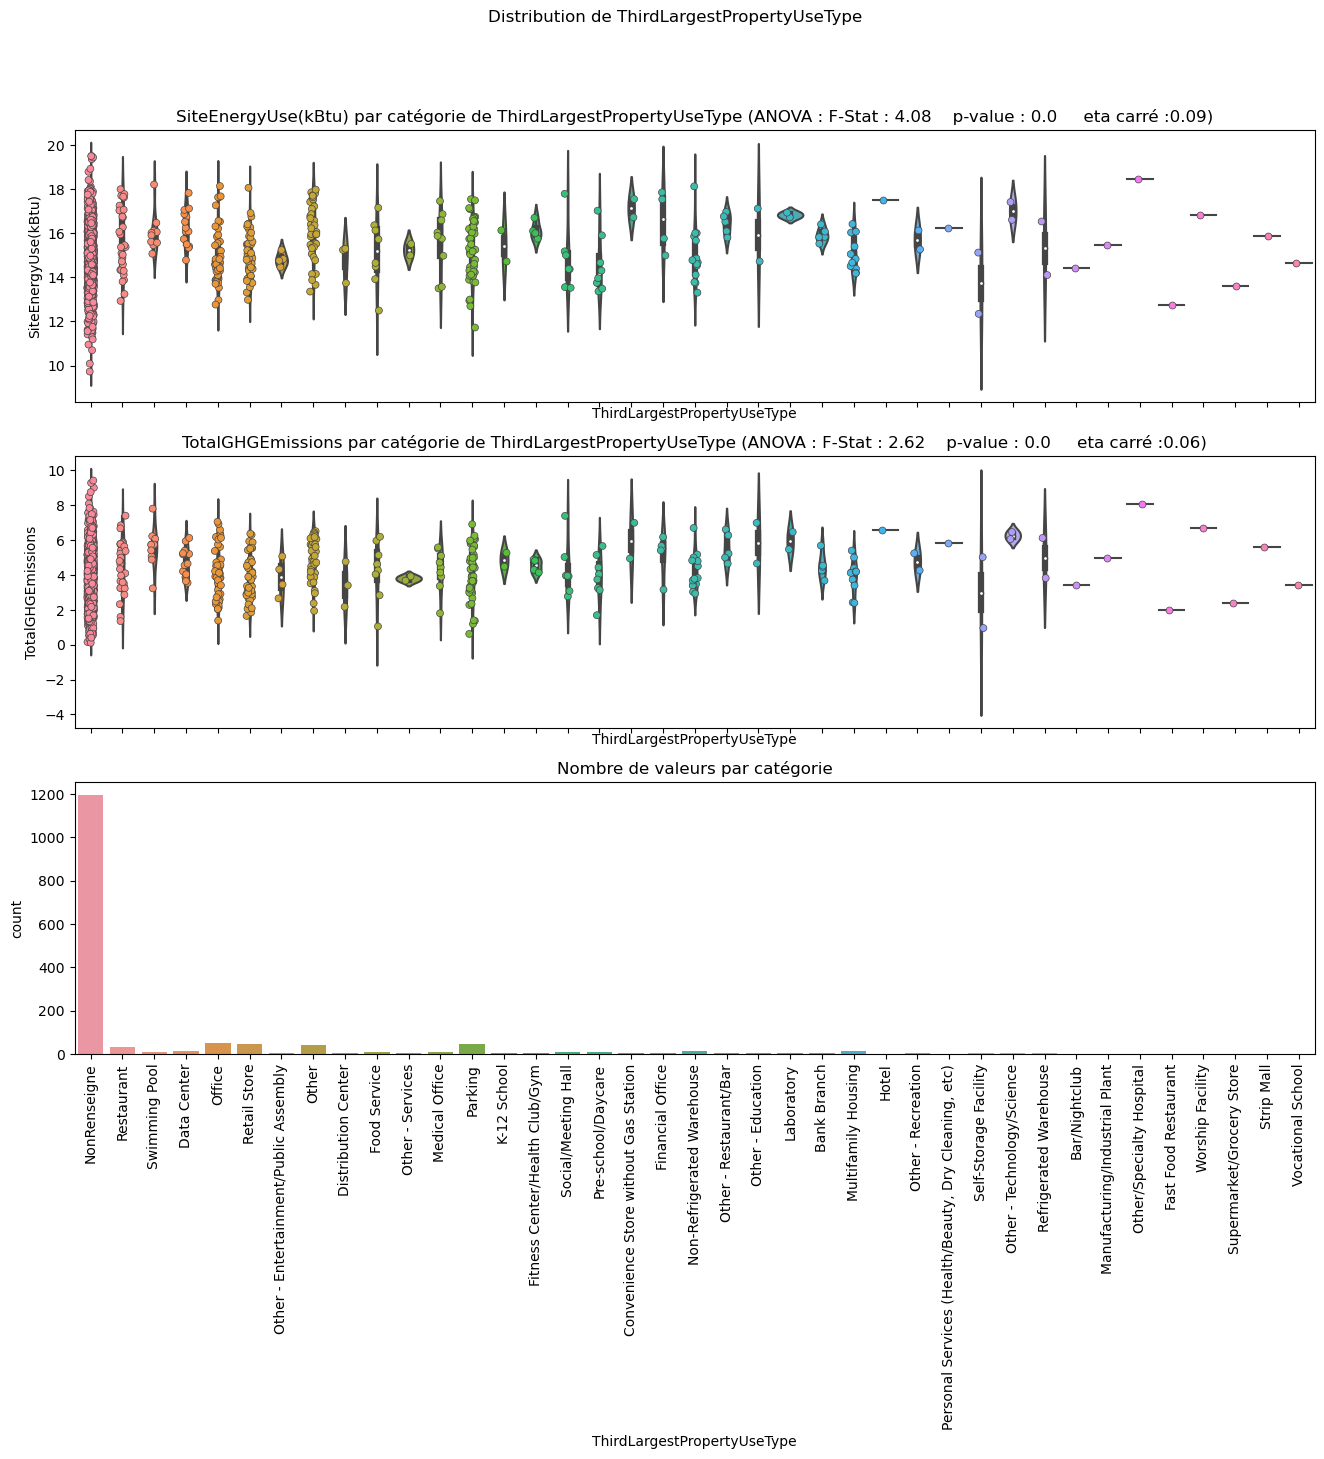

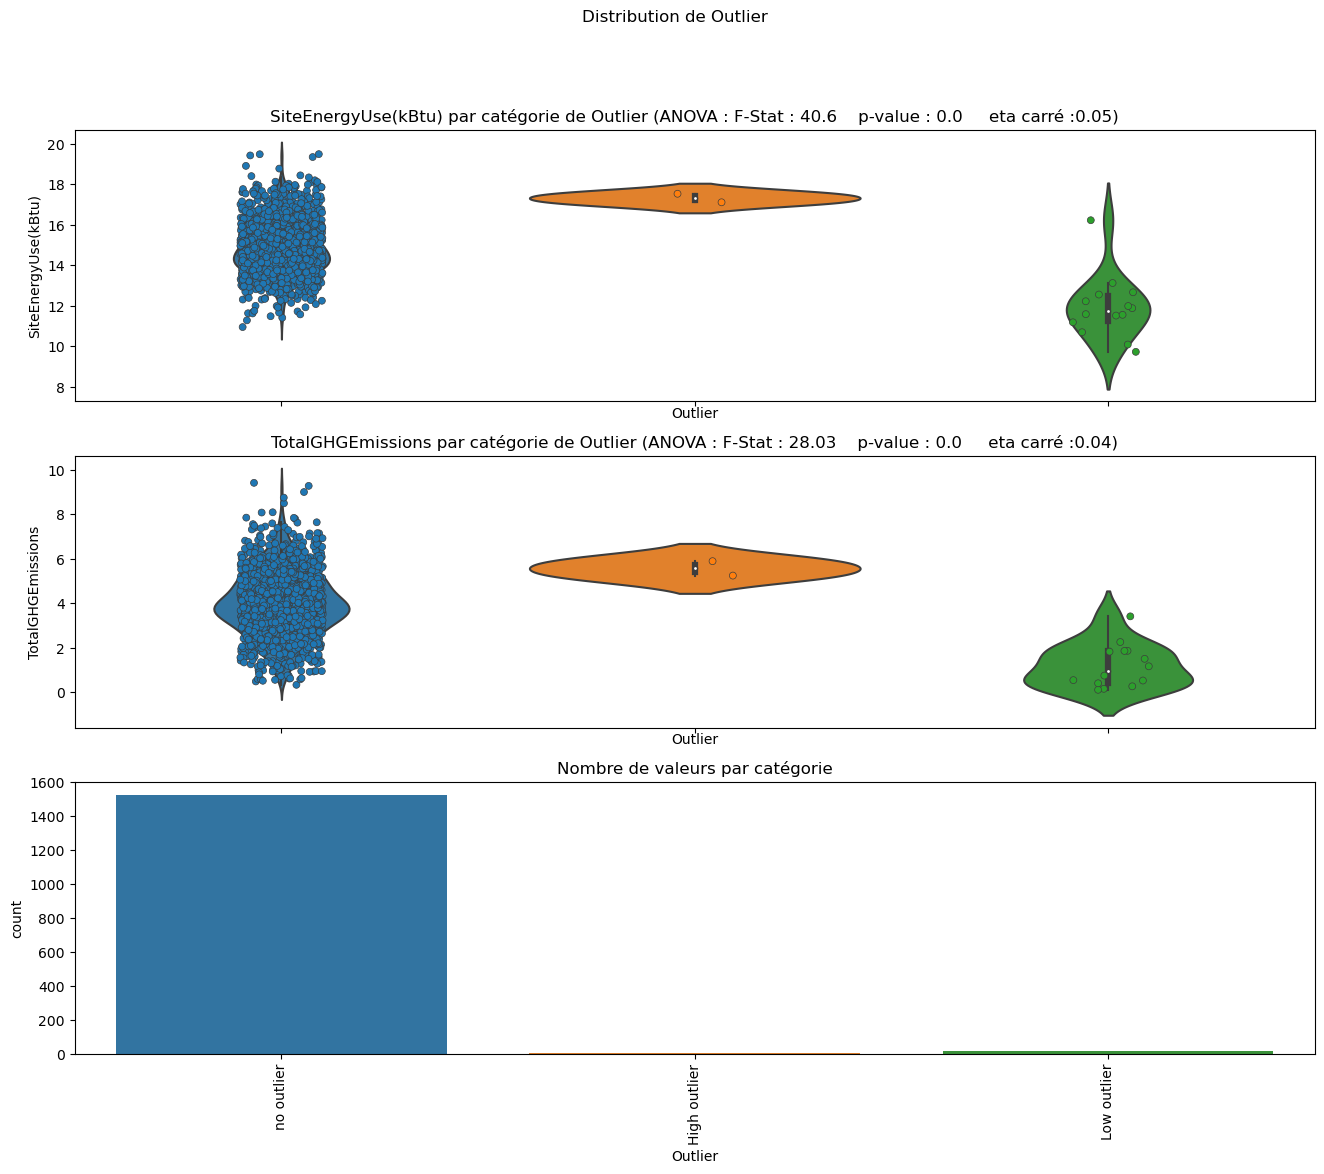

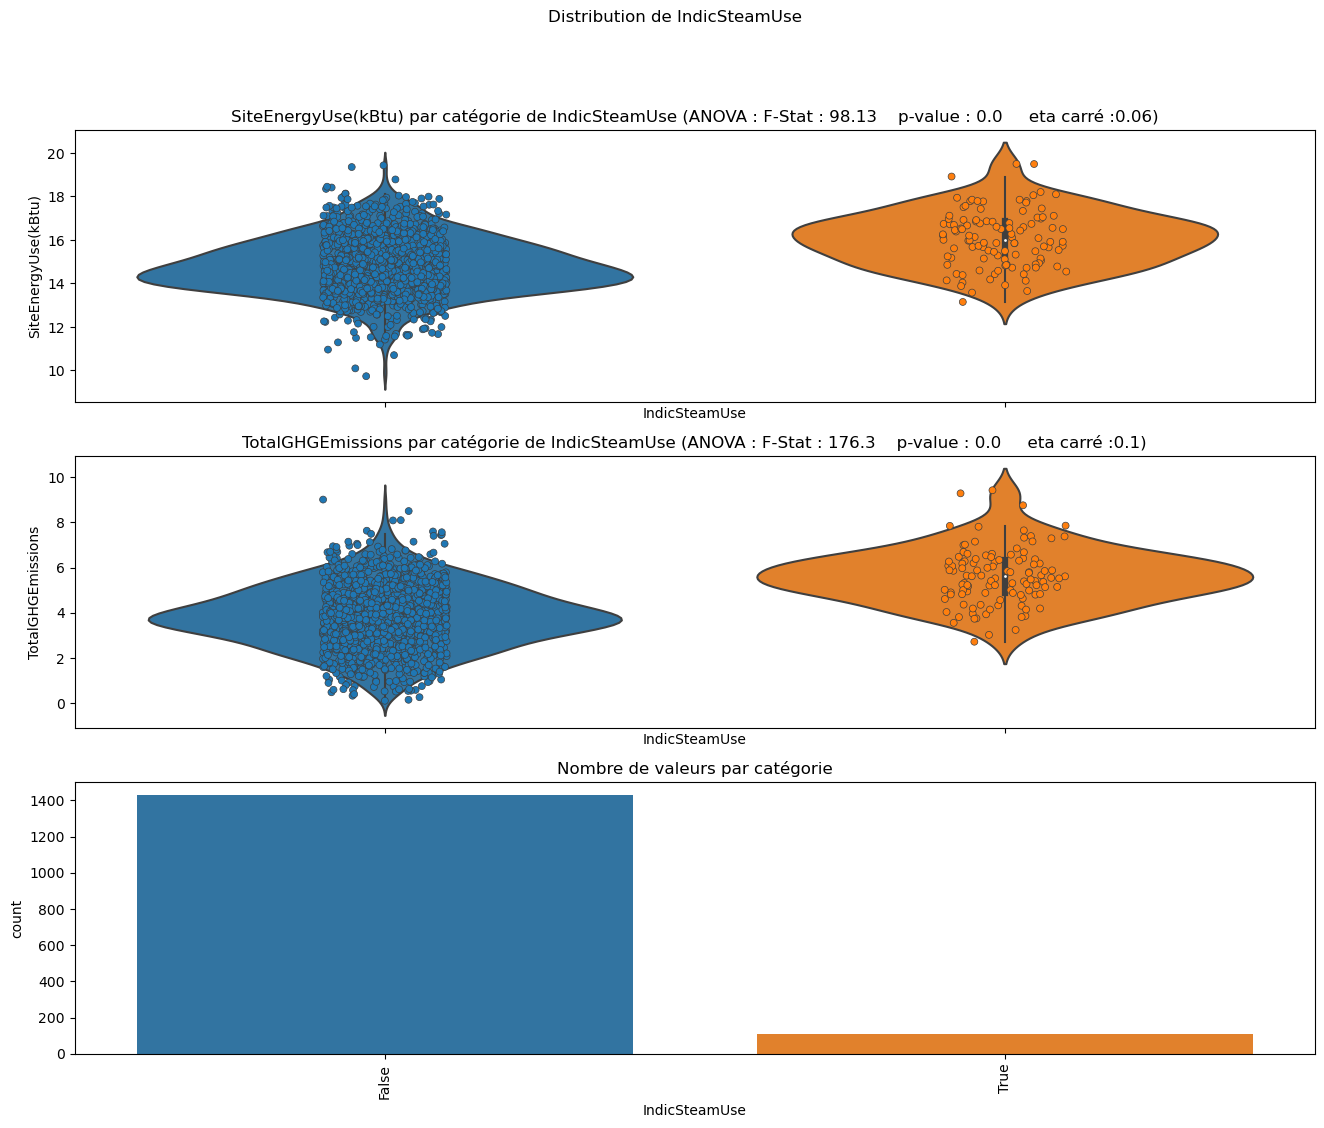

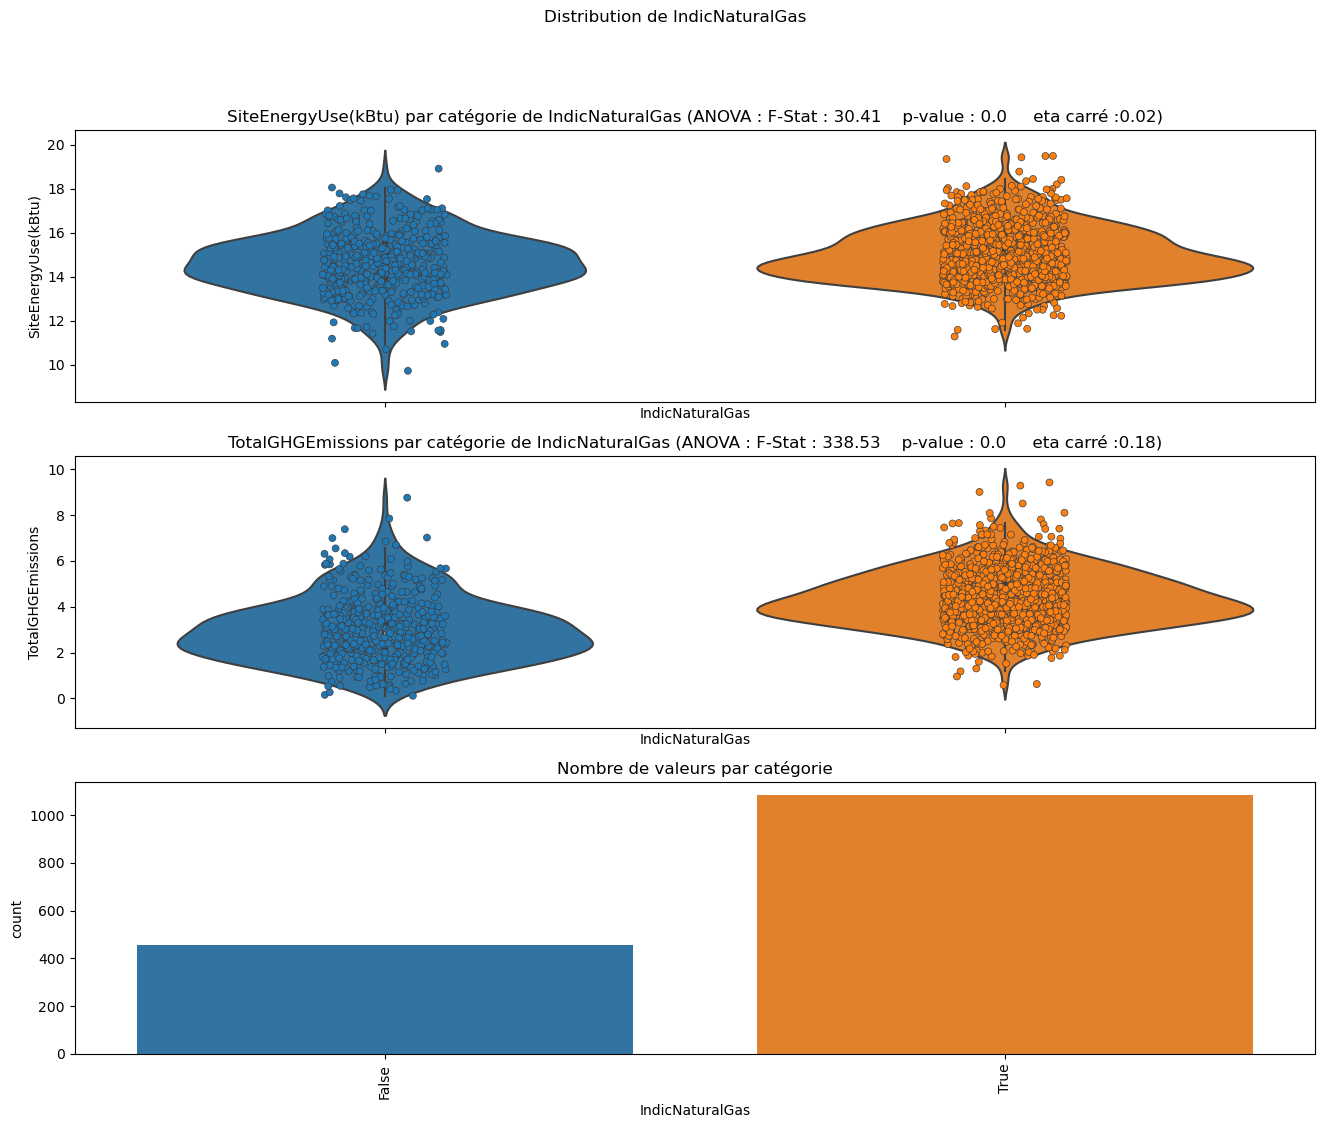

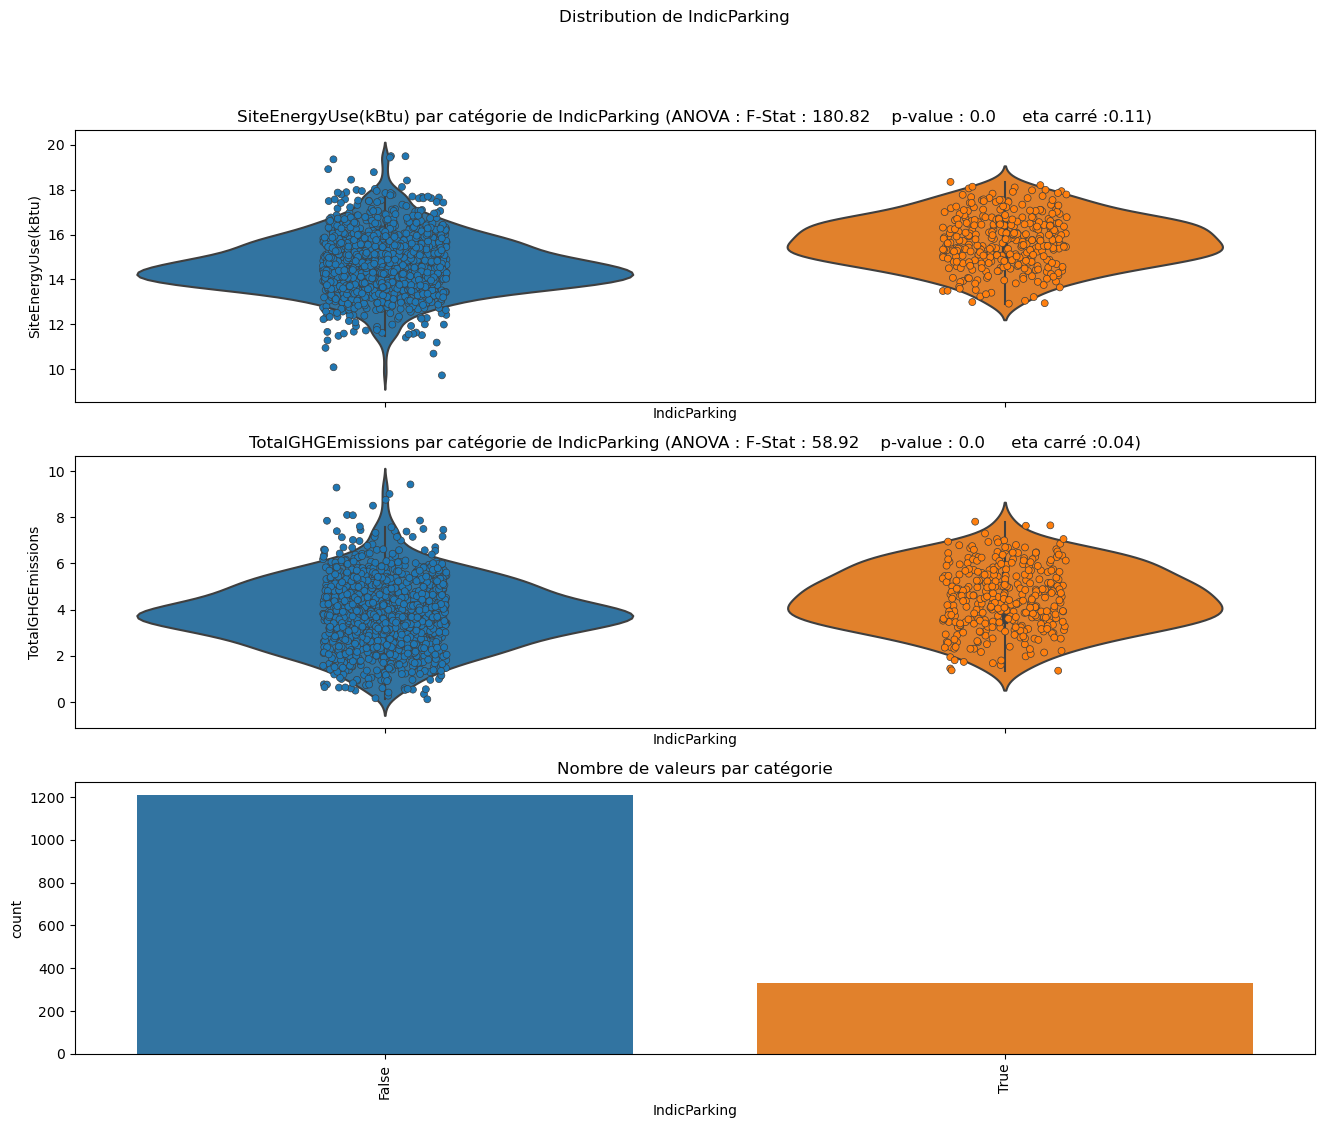

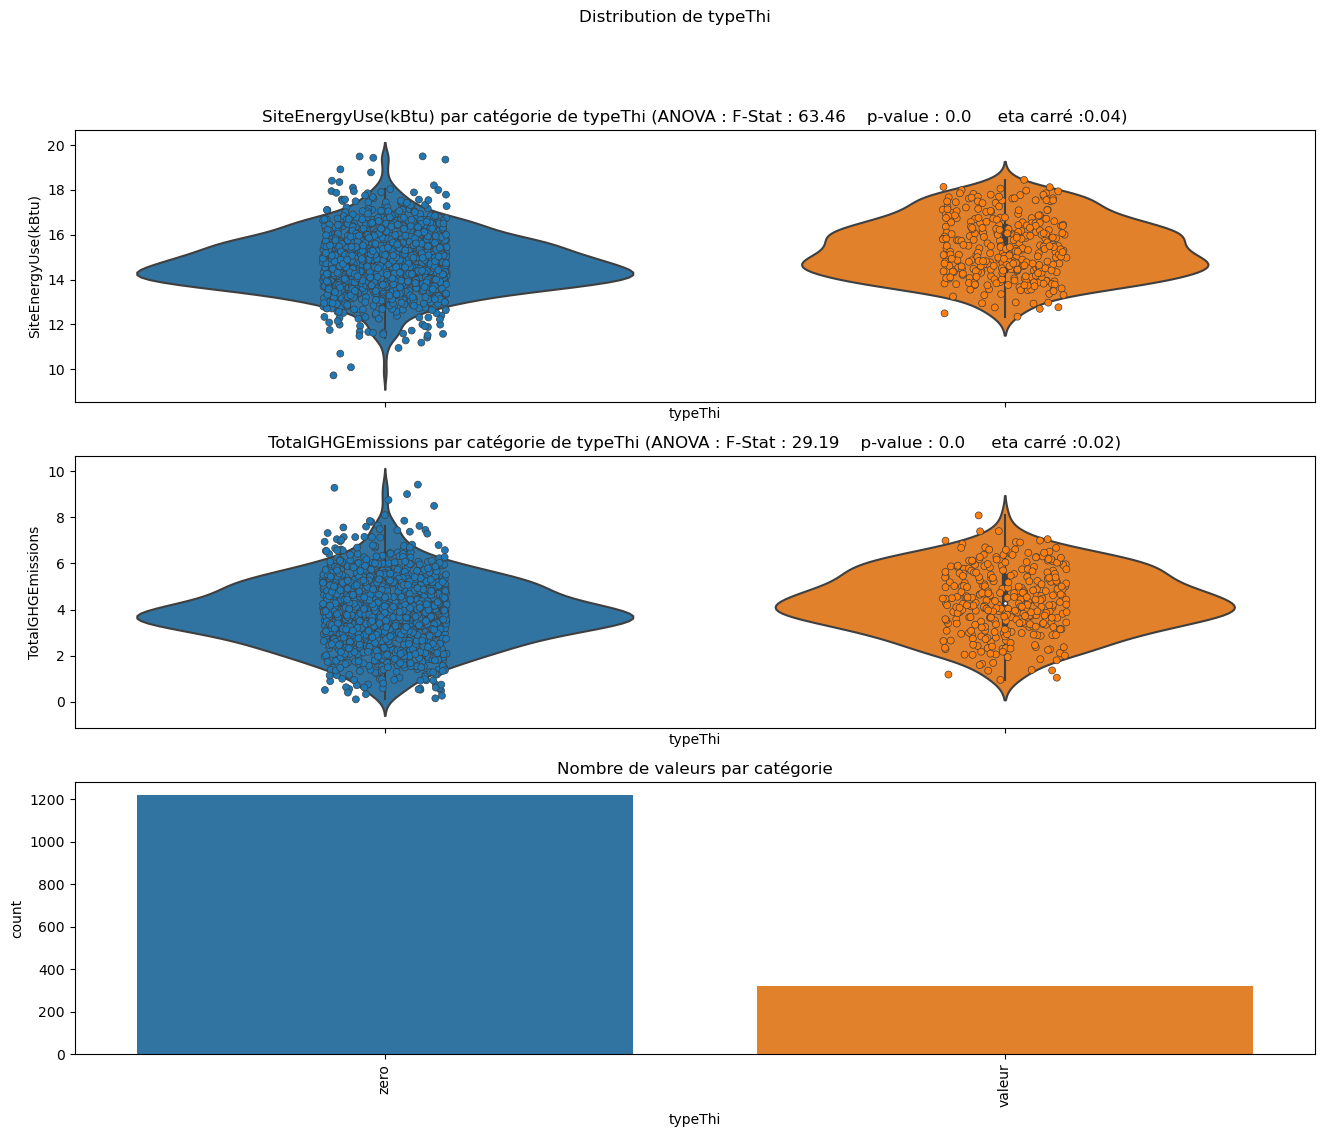

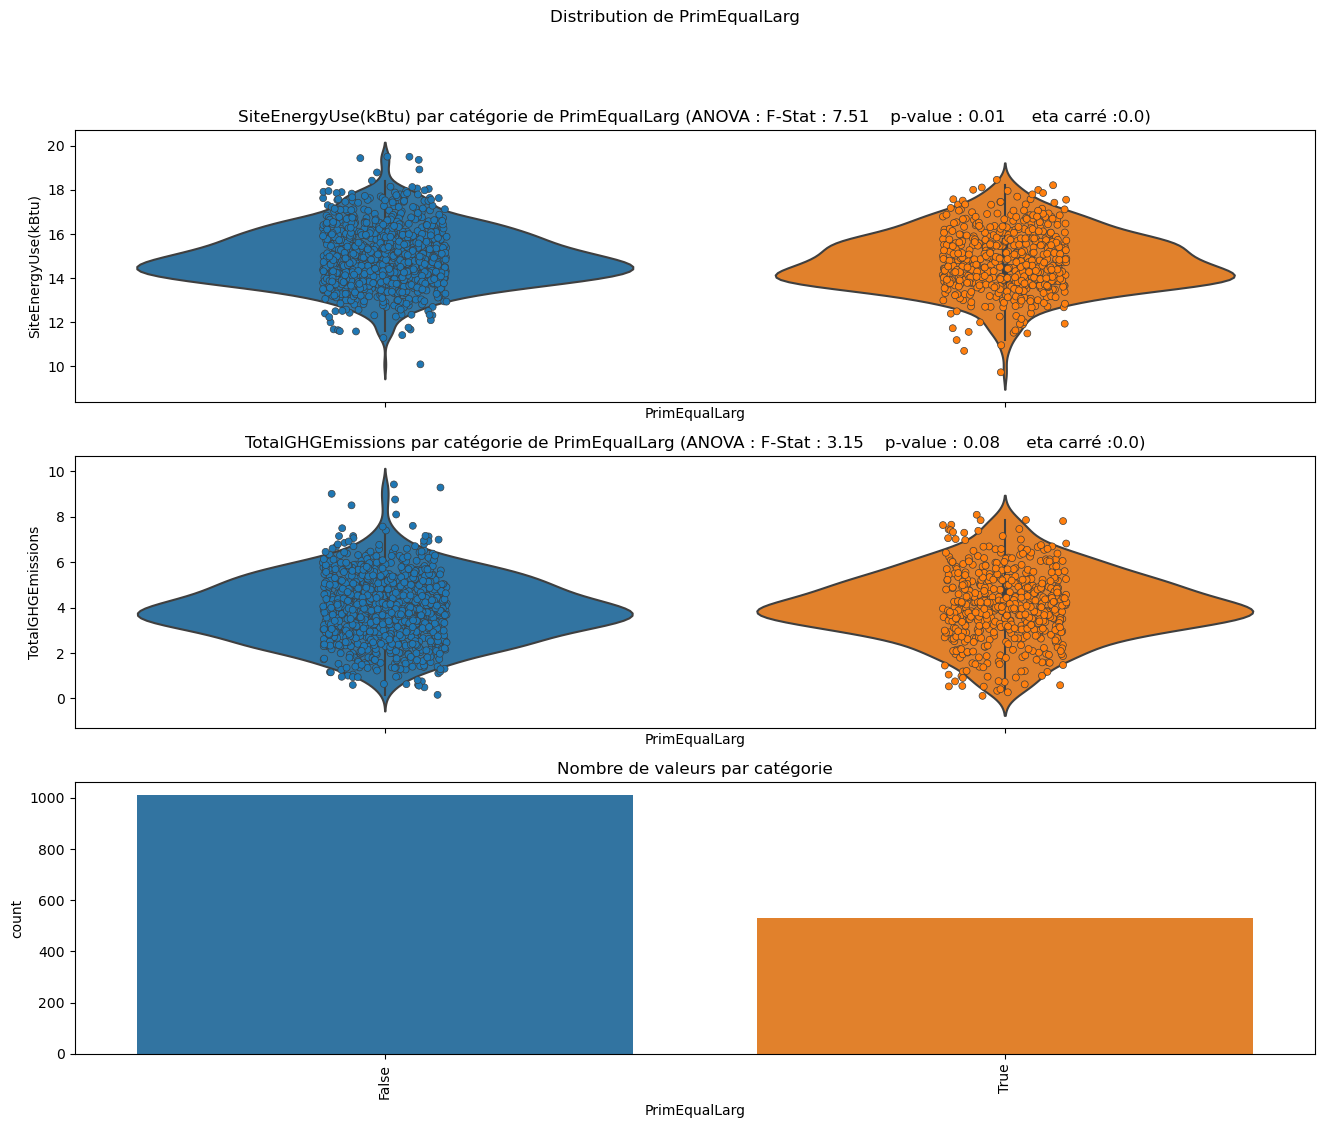

In [51]:
# 3 graphs : 1 violinplot/stripplot par label, 1 countplot
if graphs == True:
    for i in Categ:
        f, (ax1, ax2, ax3)= plt.subplots(3,1, sharex=True, figsize=[16,12])
        plt.suptitle('Distribution de {}'.format(i))
        sns.violinplot(data=data2016f2, x=i,y='SiteEnergyUse(kBtu)', fliersize=0, ax=ax1)
        sns.stripplot(data=data2016f2, x=i,y='SiteEnergyUse(kBtu)', linewidth=0.5, ax=ax1)
        ano1=calcanova(data2016f2, i, 'SiteEnergyUse(kBtu)')
        ax1.set_title('SiteEnergyUse(kBtu) par catégorie de {} (ANOVA : F-Stat : {}    p-value : {}     eta carré :{})'\
                      .format(i,round(ano1[0][0],2),round(ano1[0][1],2),round(ano1[3]/ano1[1],2)))
        sns.violinplot(data=data2016f2, x=i,y='TotalGHGEmissions', fliersize=0, ax=ax2)
        sns.stripplot(data=data2016f2, x=i,y='TotalGHGEmissions', linewidth=0.5, ax=ax2)
        ano2=calcanova(data2016f2, i, 'TotalGHGEmissions')
        ax2.set_title('TotalGHGEmissions par catégorie de {} (ANOVA : F-Stat : {}    p-value : {}     eta carré :{})'\
                      .format(i,round(ano2[0][0],2),round(ano2[0][1],2),round(ano2[3]/ano2[1],2)))
        sns.countplot(data=data2016f2, x=i, ax=ax3)
        ax3.set_title('Nombre de valeurs par catégorie')
        plt.xticks(rotation=90)
        plt.show()

### Regroupement de catégories peu significatives ou similaires

In [52]:
np.sort(data2016f2['SecondLargestPropertyUseType'].unique())

array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'Bar/Nightclub', 'College/University',
       'Convenience Store without Gas Station', 'Courthouse',
       'Data Center', 'Distribution Center', 'Enclosed Mall',
       'Financial Office', 'Fitness Center/Health Club/Gym', 'Food Sales',
       'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel',
       'K-12 School', 'Laboratory', 'Manufacturing/Industrial Plant',
       'Medical Office', 'Movie Theater', 'Multifamily Housing',
       'Non-Refrigerated Warehouse', 'NonRenseigne', 'Office', 'Other',
       'Other - Education', 'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Public Services',
       'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services',
       'Parking', 'Performing Arts',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Pre-school/Daycare', 'Refrigerated Warehouse',
       'Repair Services (Vehicle, Shoe, Locks

In [53]:
# colonnes à regrouper
RegrT=['Strip Mall','Retail Store','Fitness Center/Health Club/Gym','Restaurant','Worship Facility','Bank Branch',\
     'Other - Recreation','Convenience Store without Gas Station','Parking','Medical Office','Social/Meeting Hall',\
      'Laboratory','Other - Entertainment/Public Assembly']
RegrS=['Hospital (General Medical & Surgical)','Other - Restaurant/Bar','Performing Arts','Refrigerated Warehouse',\
      'Repair Services (Vehicle, Shoe, Locksmith, etc)','Self-Storage Facility','Social/Meeting Hall',\
      'Swimming Pool','Worship Facility','Hotel','Enclosed Mall','Food Sales', 'K-12 School','Other - Services',\
       'Laboratory','Medical Office','Swimming Pool', 'Vocational School','Manufacturing/Industrial Plant',\
      'Food Service','Adult Education','Automobile Dealership','Other - Entertainment/Public Assembly','College/University',\
      'Other - Public Services','Other - Lodging/Residential','Bank Branch','Bar/Nightclub','Courthouse']
RegrL=['Lifestyle Center','Refrigerated Warehouse','Office','Strip Mall']
data2016f2.loc[np.isin(data2016f2['ThirdLargestPropertyUseType'],RegrT),'ThirdLargestPropertyUseType']='Regroupement'
data2016f2.loc[np.isin(data2016f2['SecondLargestPropertyUseType'],RegrS),'SecondLargestPropertyUseType']='Regroupement'
data2016f2.loc[np.isin(data2016f2['LargestPropertyUseType'],RegrL),'LargestPropertyUseType']='Regroupement'

### Relation colonnes numériques / labels

In [54]:
data2016f2.select_dtypes('number').columns

Index(['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'NumberofMainUseType',
       'NumberofAllUseType', 'SurfEtaMoy', 'SurfBatMoy', 'SumLarSecThiGFA',
       'PropBuildingsGFA'],
      dtype='object')

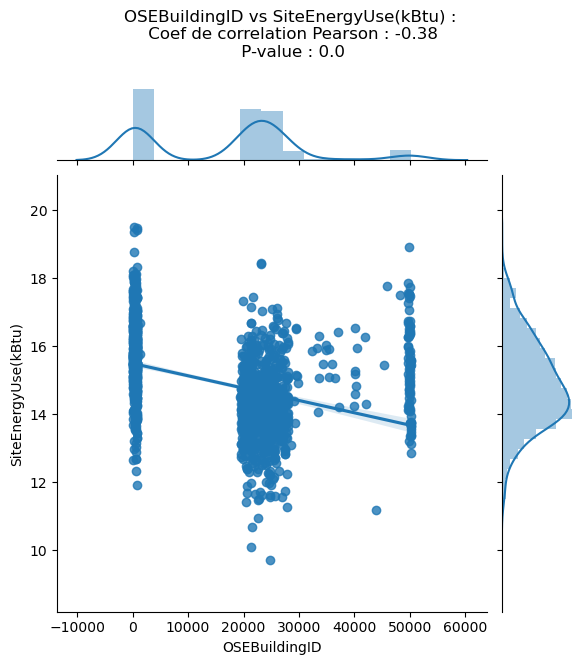

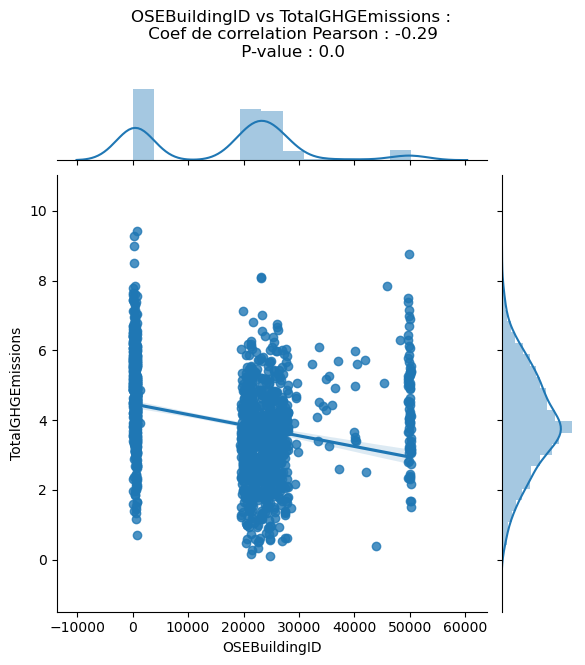

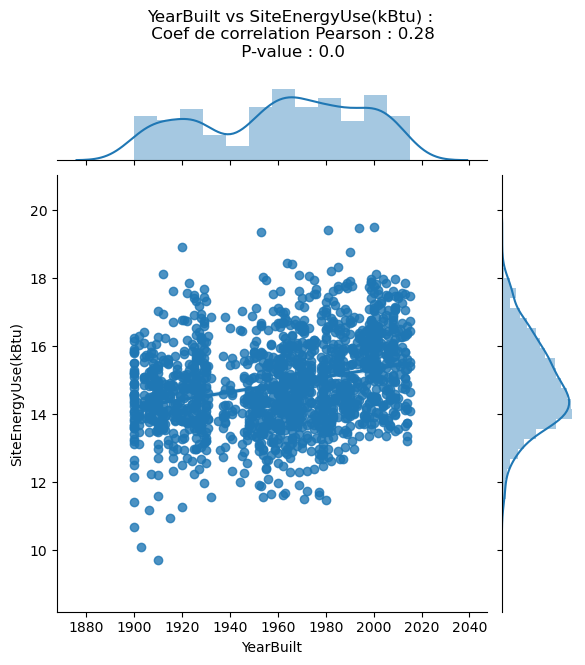

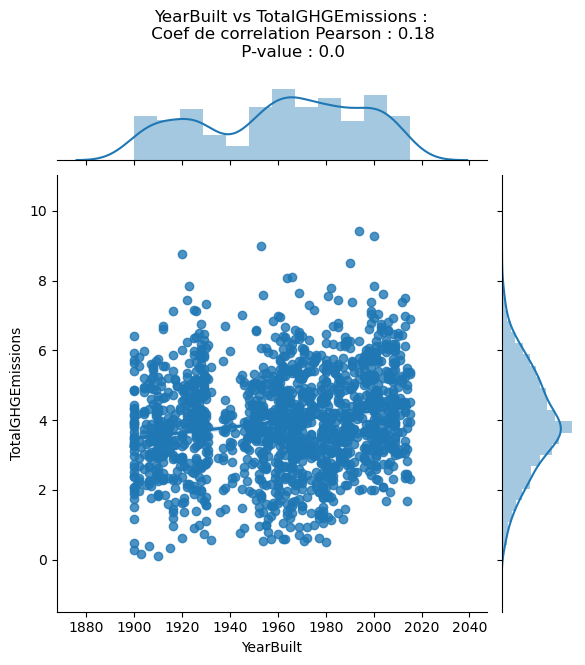

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


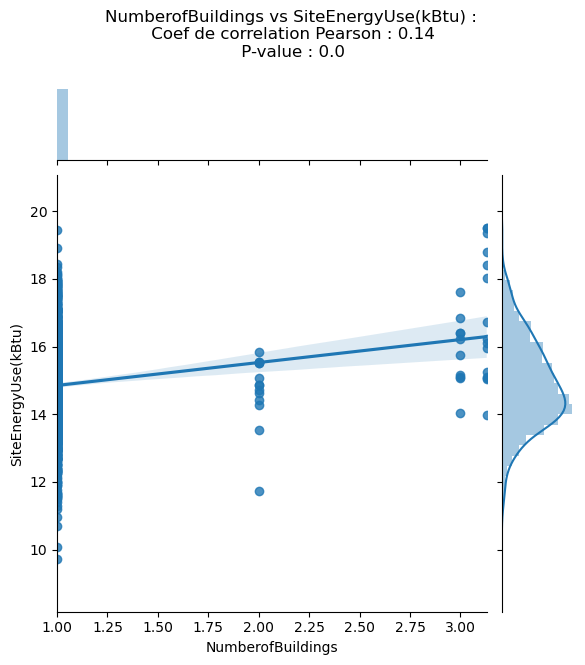

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


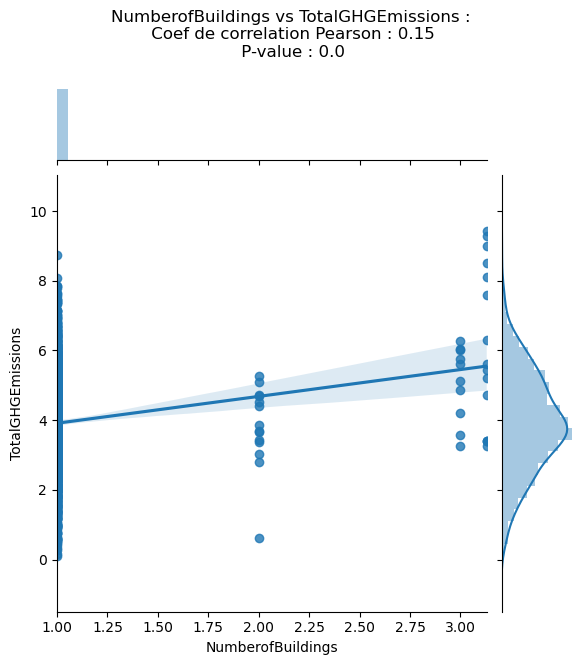

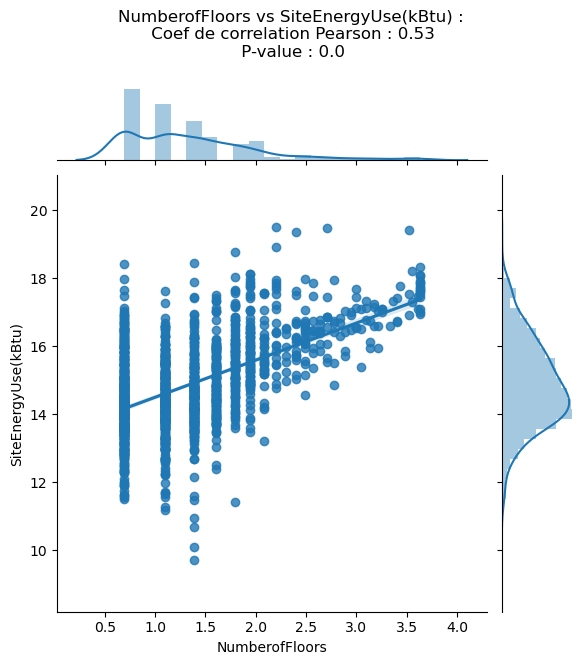

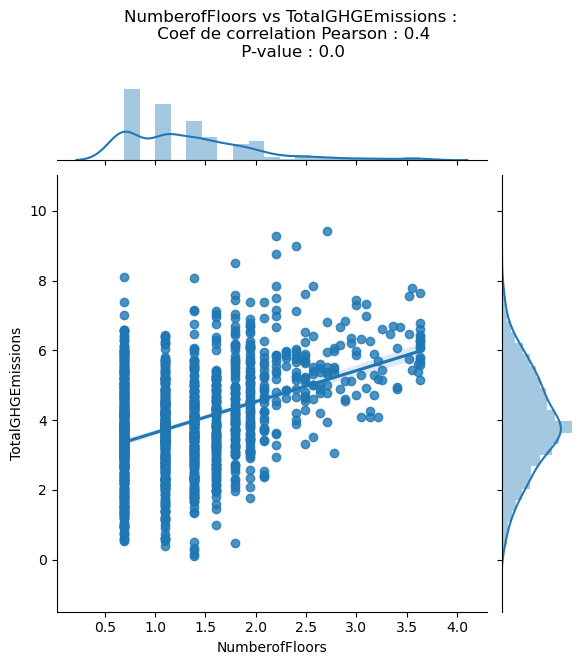

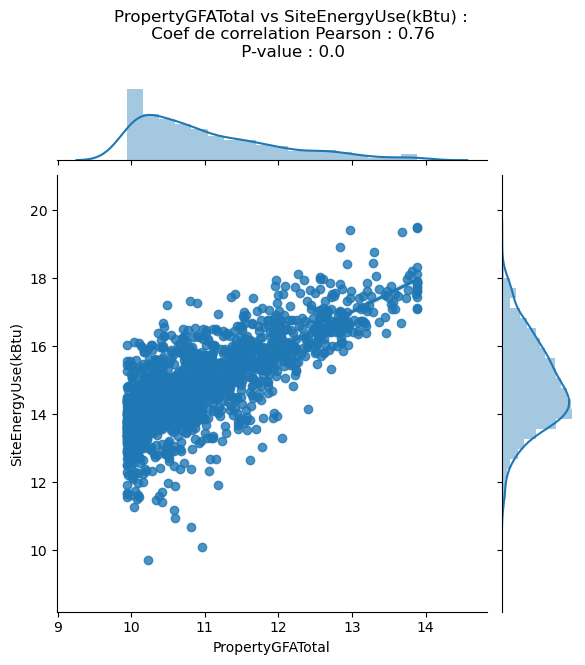

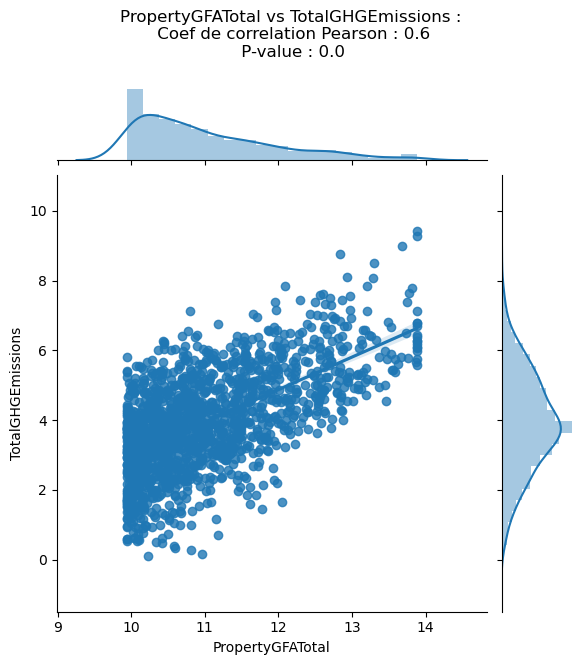

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


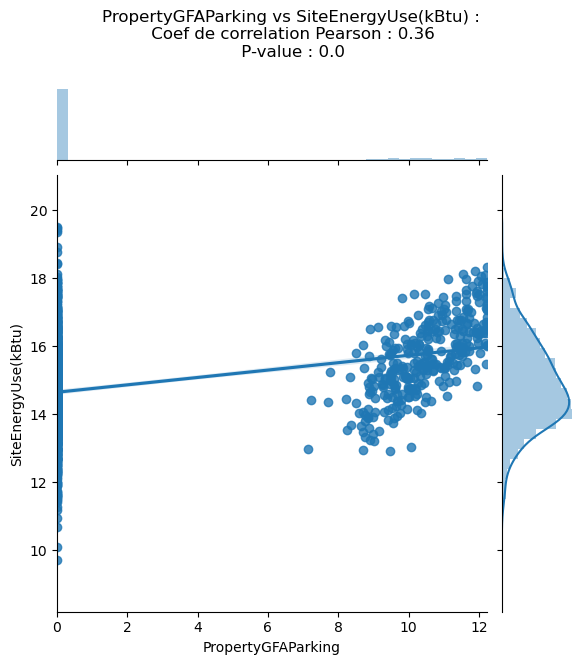

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


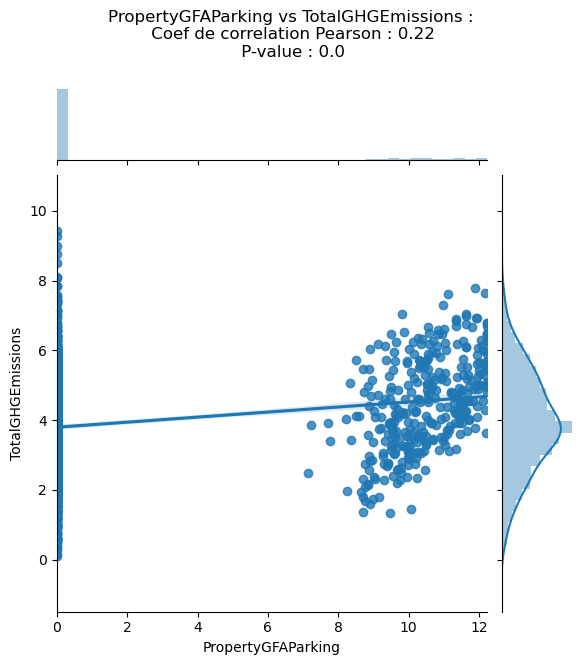

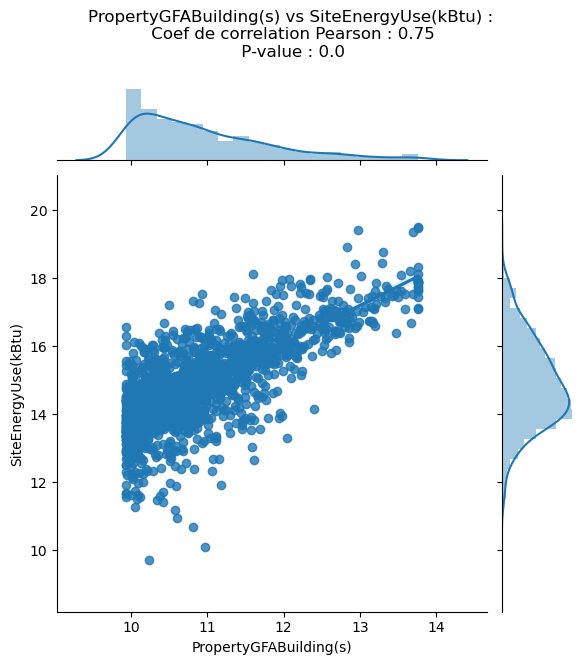

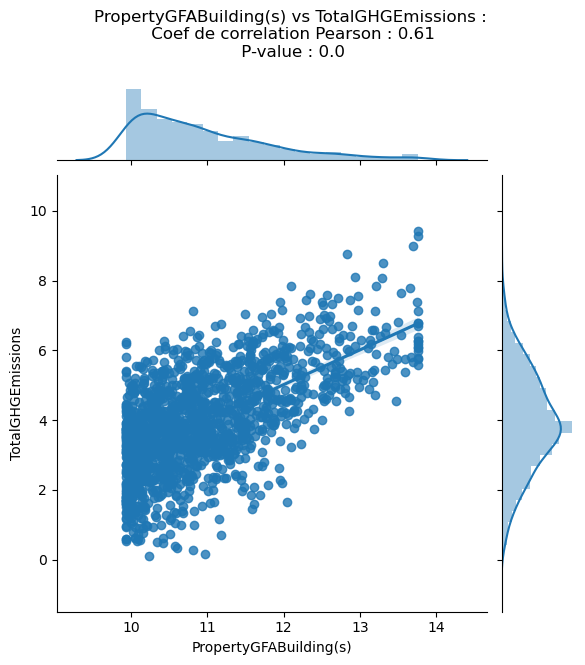

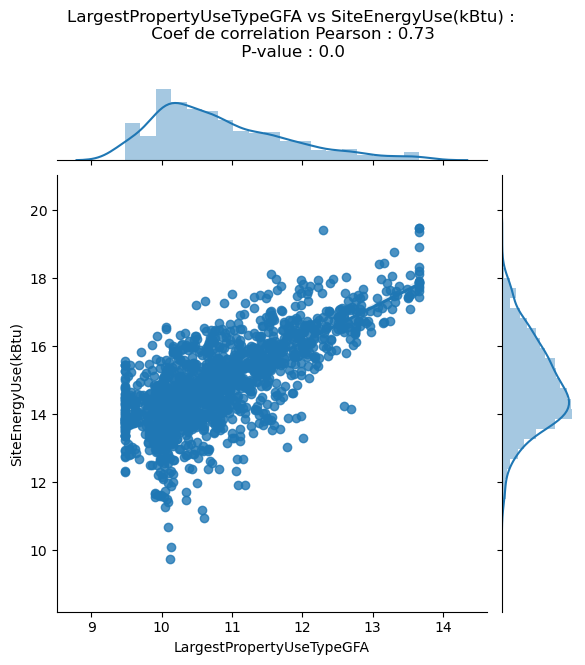

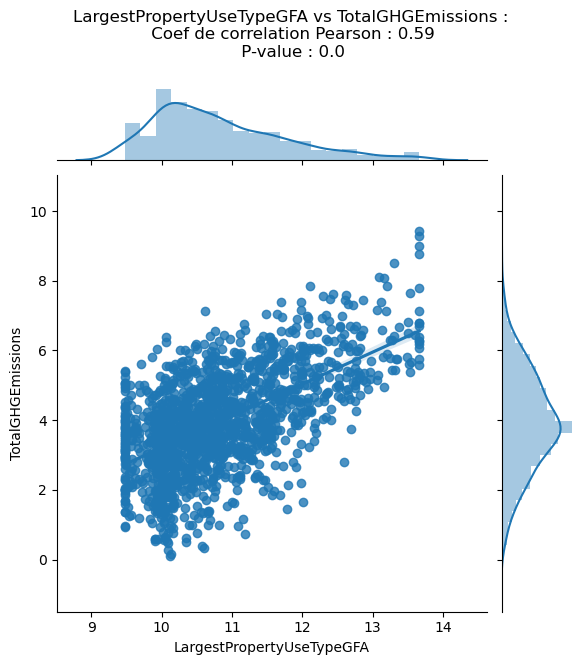

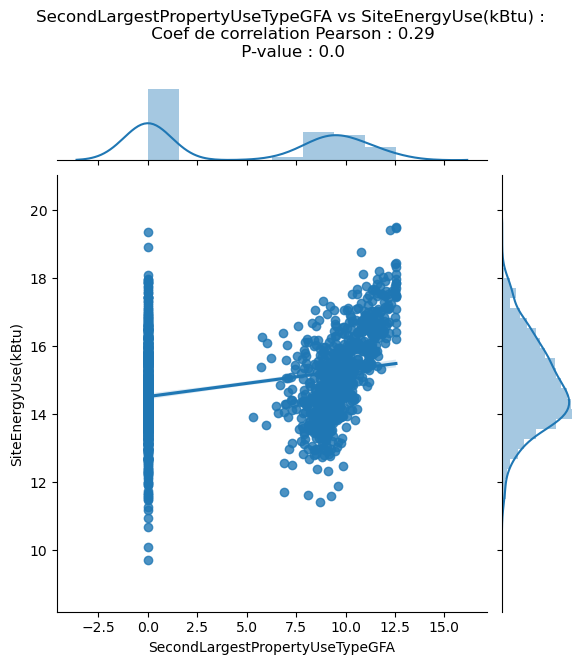

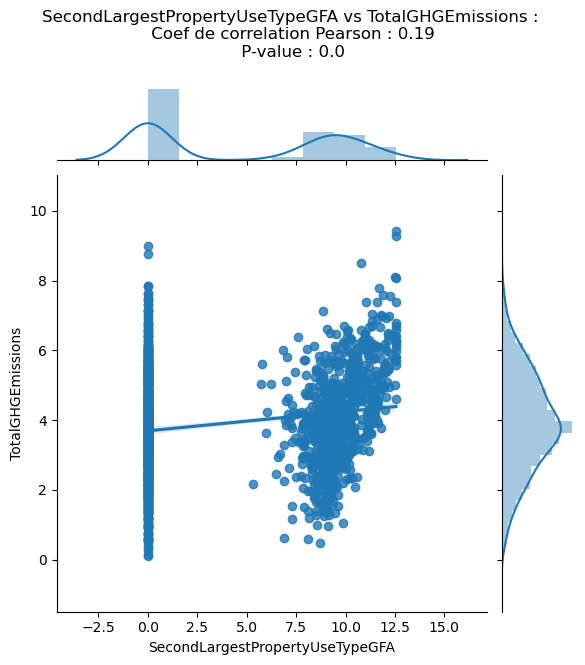

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


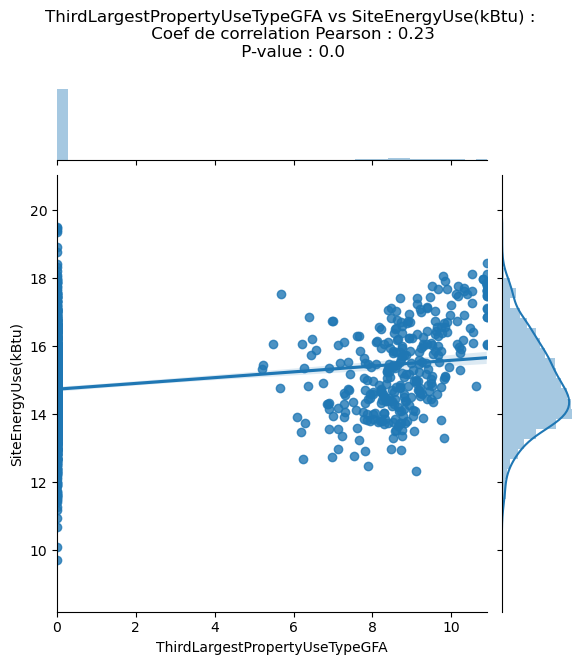

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


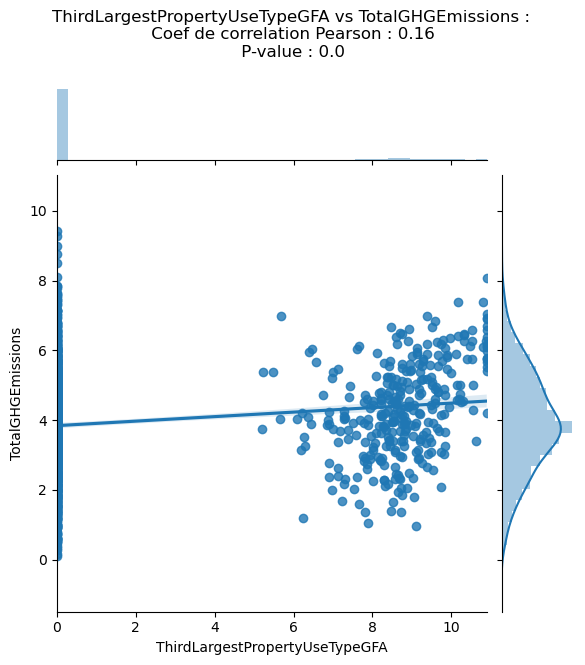

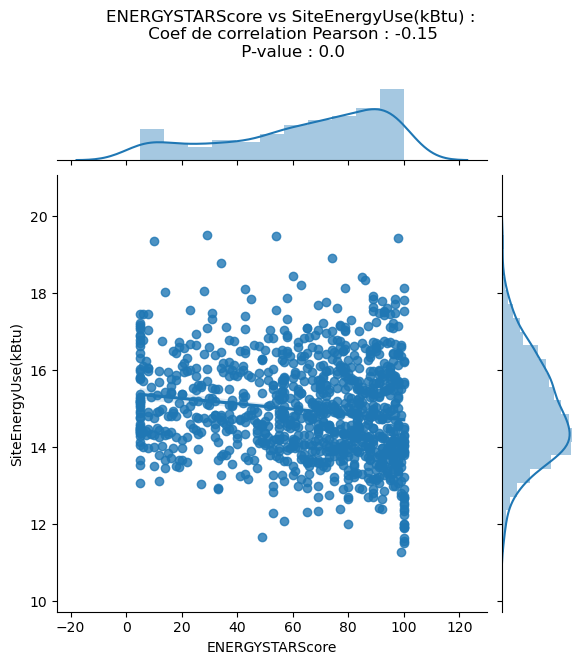

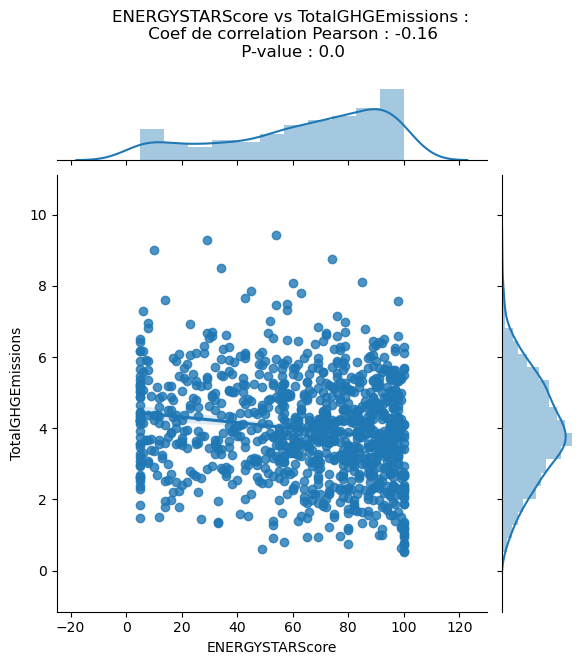

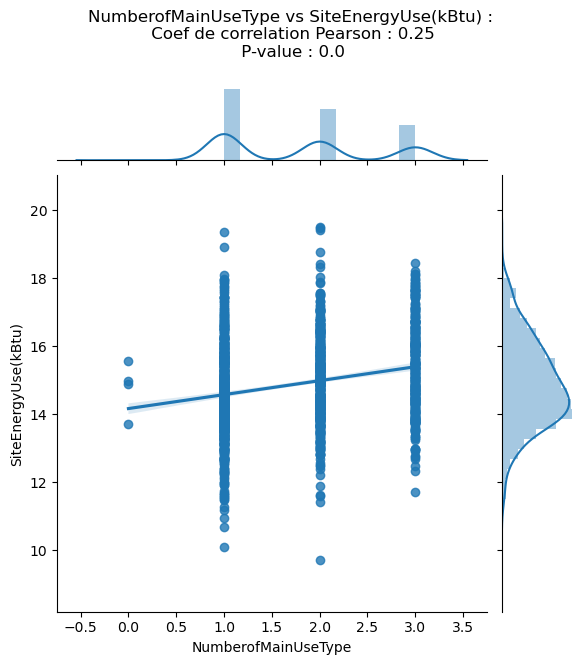

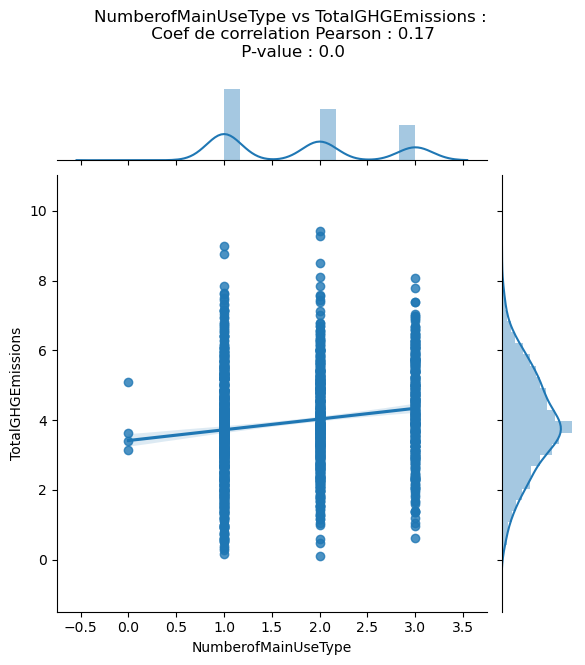

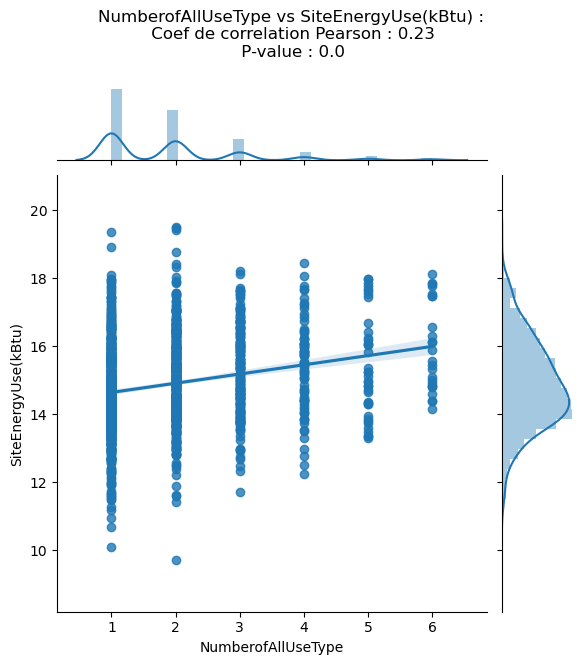

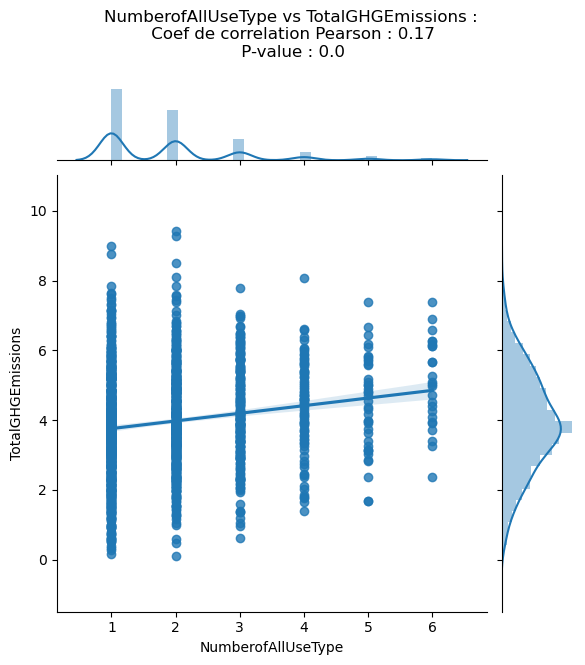

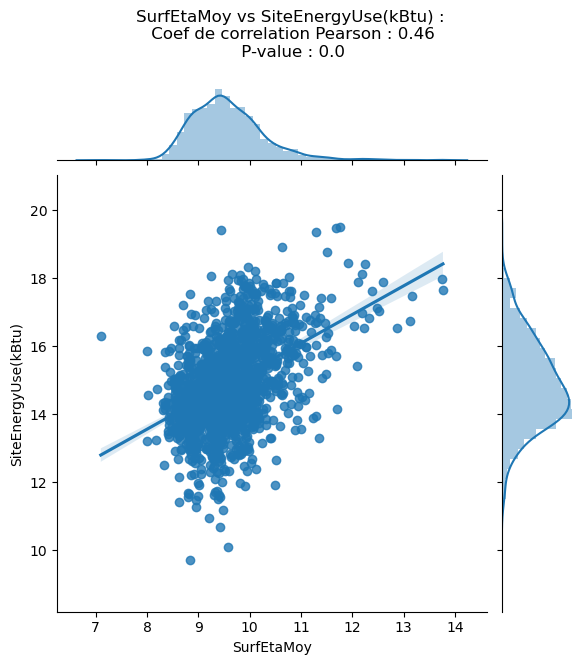

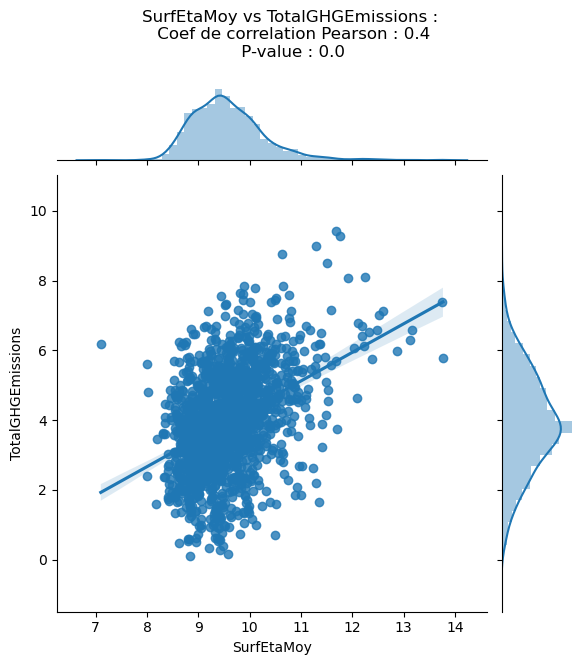

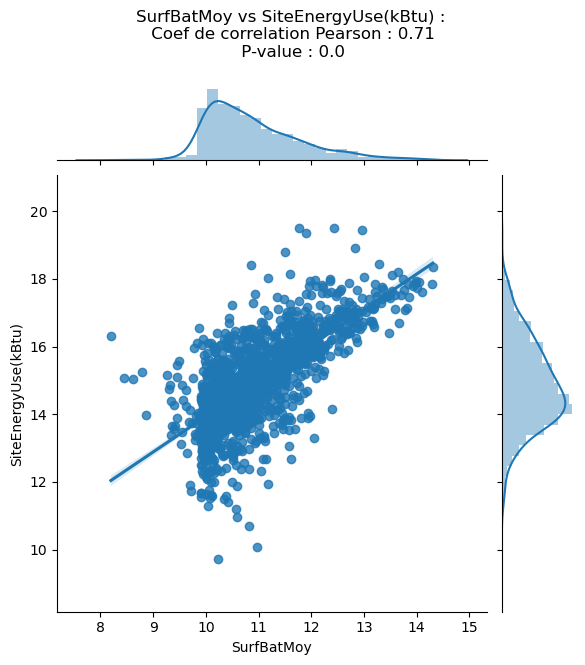

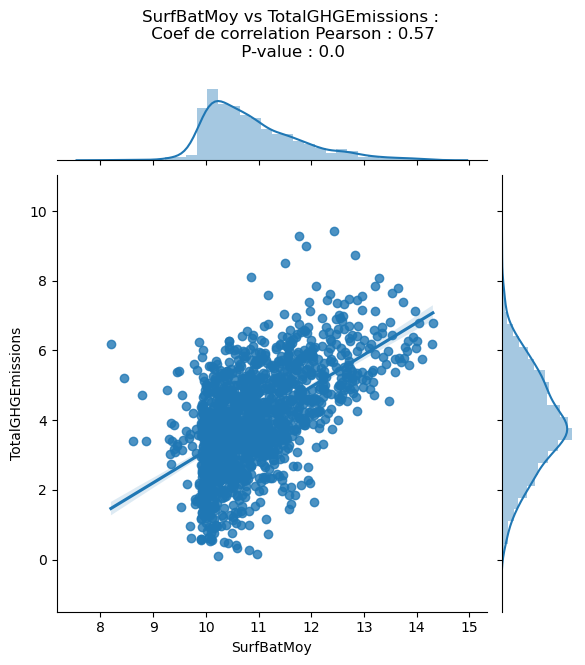

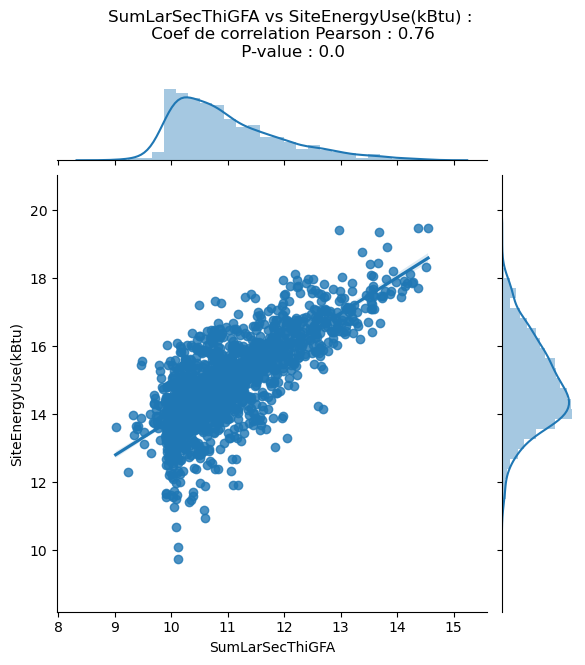

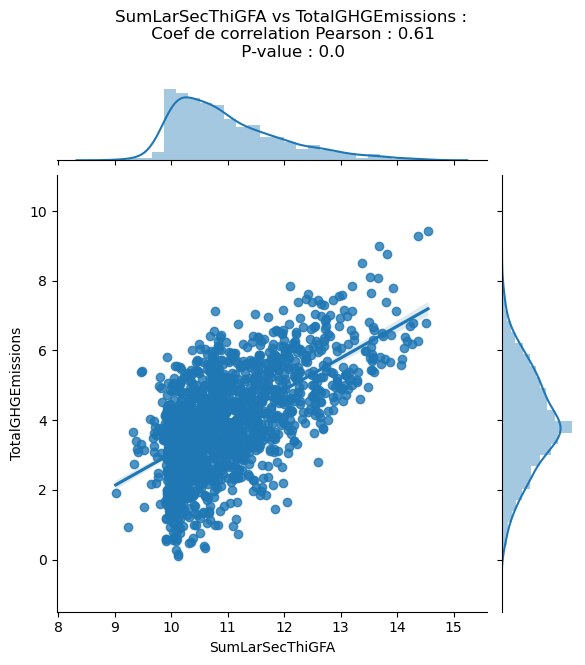

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


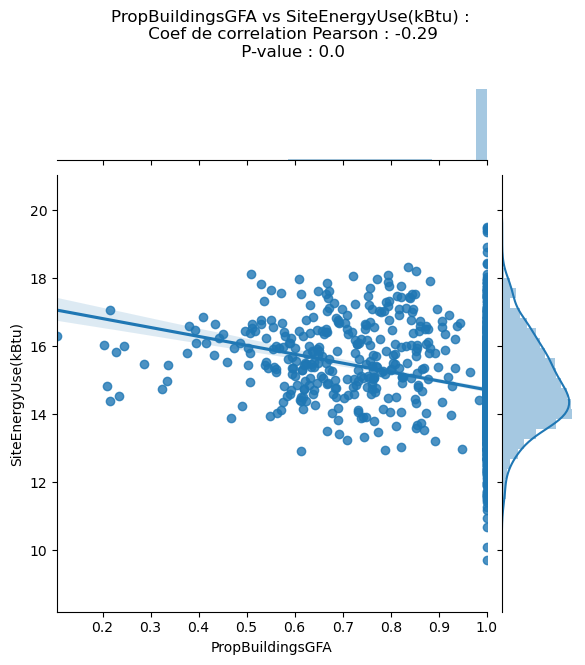

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


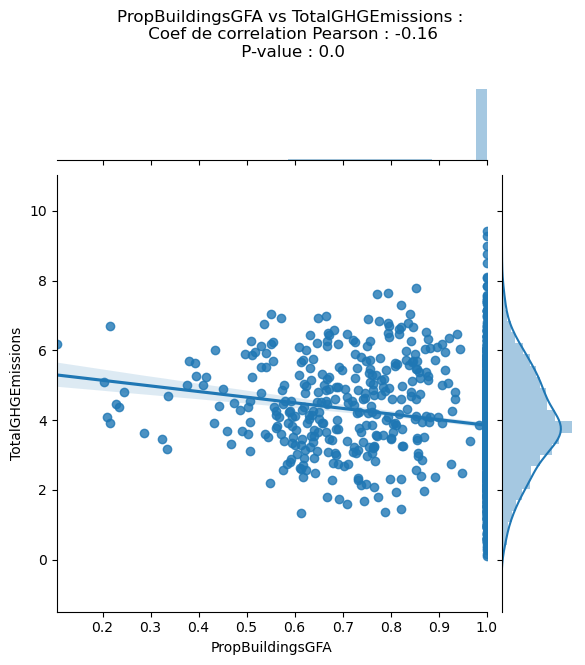

In [55]:
if graphs==True: #joinplot qui analyse la relation entre 2 colonnes numériques, avec un coef de correlation Pearson
    for i in data2016f2.select_dtypes('number').columns:
        if i not in ['SiteEnergyUse(kBtu)','TotalGHGEmissions']:
            dtemp=data2016f2[['SiteEnergyUse(kBtu)','TotalGHGEmissions',i]].dropna()
            for j in ['SiteEnergyUse(kBtu)','TotalGHGEmissions']:
                Scat(dtemp, i,j)

In [56]:
VarNum =data2016f2.select_dtypes('number').columns[np.isin(data2016f2.select_dtypes('number').columns,\
                                                   ['SiteEnergyUse(kBtu)','TotalGHGEmissions'], invert=True)]
VarNum #variables numériques sans les labels

Index(['OSEBuildingID', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'NumberofMainUseType', 'NumberofAllUseType', 'SurfEtaMoy', 'SurfBatMoy',
       'SumLarSecThiGFA', 'PropBuildingsGFA'],
      dtype='object')

In [57]:
data2016f2[data2016f2.select_dtypes('number').columns].corr()

OSEBuildingID  YearBuilt  NumberofBuildings  \
OSEBuildingID                         1.000000   0.021090          -0.033129   
YearBuilt                             0.021090   1.000000           0.046610   
NumberofBuildings                    -0.033129   0.046610           1.000000   
NumberofFloors                       -0.351806   0.077551          -0.022002   
PropertyGFATotal                     -0.516675   0.287216           0.105938   
PropertyGFAParking                   -0.272230   0.368871          -0.037628   
PropertyGFABuilding(s)               -0.508018   0.227626           0.118182   
LargestPropertyUseTypeGFA            -0.485702   0.274504           0.128418   
SecondLargestPropertyUseTypeGFA      -0.167822   0.107222          -0.014350   
ThirdLargestPropertyUseTypeGFA       -0.141552   0.018398          -0.006873   
ENERGYSTARScore                      -0.050152  -0.049163          -0.048761   
SiteEnergyUse(kBtu)                  -0.379111   0.278921           0.144506   
TotalGHGEmissions                    -0.291392   0.176420           0.150656   
NumberofMainUseType                  -0.141386   0.073451          -0.013727   
NumberofAllUseType                   -0.103706   0.074110           0.014547   
SurfEtaMoy                           -0.311831   0.211546           0.178986   
SurfBatMoy                           -0.508893   0.212974          -0.104829   
SumLarSecThiGFA                      -0.491287   0.286771           0.128840   
PropBuildingsGFA                      0.202695  -0.364829           0.032990   

                                 NumberofFloors  PropertyGFATotal  \
OSEBuildingID                         -0.351806         -0.516675   
YearBuilt                              0.077551          0.287216   
NumberofBuildings                     -0.022002          0.105938   
NumberofFloors                         1.000000          0.662266   
PropertyGFATotal                       0.662266          1.000000   
PropertyGFAParking                     0.448235          0.473281   
PropertyGFABuilding(s)                 0.640020          0.978577   
LargestPropertyUseTypeGFA              0.620377          0.946777   
SecondLargestPropertyUseTypeGFA        0.331512          0.355037   
ThirdLargestPropertyUseTypeGFA         0.251001          0.268810   
ENERGYSTARScore                        0.181800          0.155327   
SiteEnergyUse(kBtu)                    0.533533          0.759976   
TotalGHGEmissions                      0.397626          0.604943   
NumberofMainUseType                    0.248932          0.261604   
NumberofAllUseType                     0.214515          0.235878   
SurfEtaMoy                            -0.119469          0.629330   
SurfBatMoy                             0.654228          0.950702   
SumLarSecThiGFA                        0.647744          0.975157   
PropBuildingsGFA                      -0.313991         -0.386715   

                                 PropertyGFAParking  PropertyGFABuilding(s)  \
OSEBuildingID                             -0.272230               -0.508018   
YearBuilt                                  0.368871                0.227626   
NumberofBuildings                         -0.037628                0.118182   
NumberofFloors                             0.448235                0.640020   
PropertyGFATotal                           0.473281                0.978577   
PropertyGFAParking                         1.000000                0.318754   
PropertyGFABuilding(s)                     0.318754                1.000000   
LargestPropertyUseTypeGFA                  0.369681                0.944982   
SecondLargestPropertyUseTypeGFA            0.360387                0.312434   
ThirdLargestPropertyUseTypeGFA             0.194412                0.256318   
ENERGYSTARScore                            0.044916                0.158922   
SiteEnergyUse(kBtu)                        0.355266                0.747287   
TotalGHGEmissions       

### Tableau récap de coefficient de corrélation avec heatmap

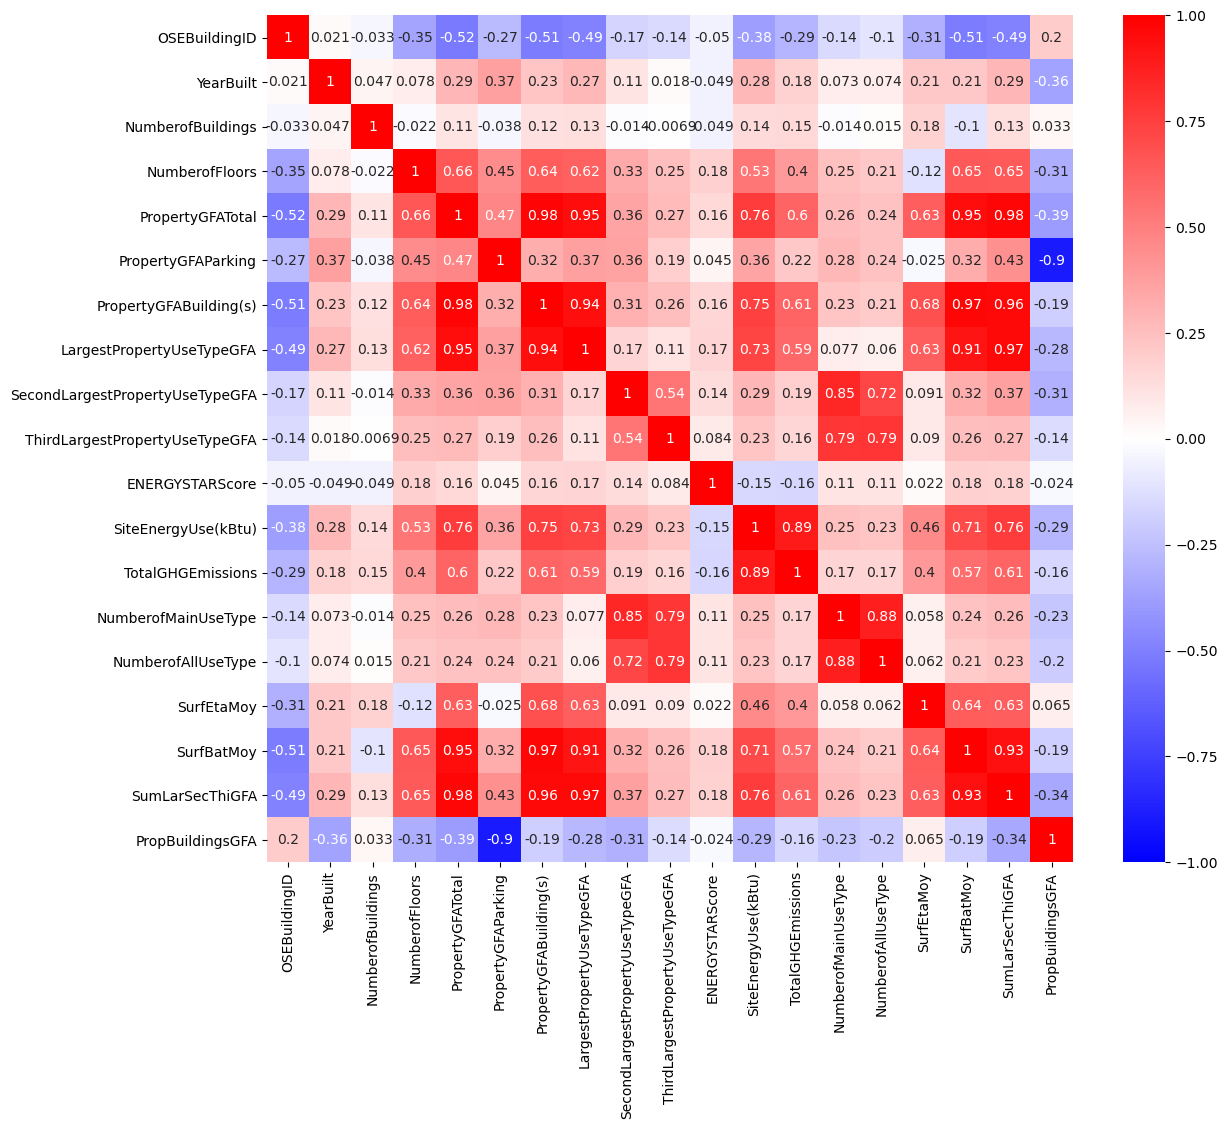

In [58]:
if graphs== True:
    plt.figure(figsize=[13,11])
    sns.heatmap(data2016f2[data2016f2.select_dtypes('number').columns].corr(), cmap='bwr', vmin=-1,vmax=1, annot=True)

In [59]:
data2016f2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 3375
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1540 non-null   int64  
 1   BuildingType                     1540 non-null   object 
 2   PrimaryPropertyType              1540 non-null   object 
 3   YearBuilt                        1540 non-null   int64  
 4   NumberofBuildings                1488 non-null   float64
 5   NumberofFloors                   1540 non-null   float64
 6   PropertyGFATotal                 1540 non-null   float64
 7   PropertyGFAParking               1540 non-null   float64
 8   PropertyGFABuilding(s)           1540 non-null   float64
 9   LargestPropertyUseType           1540 non-null   object 
 10  LargestPropertyUseTypeGFA        1536 non-null   float64
 11  SecondLargestPropertyUseType     1540 non-null   object 
 12  SecondLargestPropert

### Enregistrement pour utilisation dans la partie modélisation

In [60]:
data2016f2.to_csv('C://Users//hp//Documents//openclassrooms//projet4//2016final.csv')